In [1]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install matplotlib-venn -q
from matplotlib_venn import venn2
from scipy import stats
from scipy.stats import mannwhitneyu

# Исследование сезонной динамики и популярности мероприятий на Яндекс Афиша

## Цели и задачи проекта

`Цель`: провести исследовательский и статистический анализ заказов билетов на сервисе Яндекс Афиша за период с июня по октябрь 2024 года, чтобы выявить изменения пользовательских предпочтений осенью 2024 года, определить наиболее востребованные события и партнёров, а также проверить гипотезы о различиях в поведении пользователей мобильных и стационарных устройств.

`Задачи`: загрузить и проверить данные, выполнить предобработку, исследовать сезонную динамику и популярность событий, проанализировать активность пользователей, проверить статистические гипотезы и интерпретировать результаты.

## Описание данных


Для анализа используются данные о бронировании билетов на сервисе Яндекс Афиша за период с 1 июня по 30 октября 2024 года. 

Данные состоят из трёх датасетов:

- `final_tickets_orders_df.csv` содержит информацию обо всех заказах билетов, совершённых с двух типов устройств — мобильных и стационарных;
- `final_tickets_events_df` содержит информацию о событиях, включая город и регион события, а также информацию о площадке проведения мероприятия (фильмы из набора исключены, поскольку их доля, как показал дашборд, слишком мала);
- `final_tickets_tenge_df.csv` содержит информацию о курсе тенге к российскому рублю за 2024 год.

**Описание датасета `final_tickets_orders_df.csv`**:

 - `order_id` — уникальный идентификатор заказа;
 - `user_id` — уникальный идентификатор пользователя;
 - `created_dt_msk` — дата создания заказа (московское время);
 - `created_ts_msk` — дата и время создания заказа (московское время);
 - `event_id` — идентификатор мероприятия; 
 - `cinema_circuit` — сеть кинотеатров (если не применимо, то здесь будет значение 'нет');
 - `age_limit` — возрастное ограничение мероприятия;
 - `currency_code` — валюта оплаты, например rub для российских рублей;
 - `device_type_canonical` — тип устройства, с которого был оформлен заказ, например mobile для мобильных устройств, desktop для стационарных;
 - `revenue` — выручка от заказа;
 - `service_name` — название билетного оператора;
 - `tickets_count` — количество купленных билетов;
 - `total` — общая сумма заказа;
 - `days_since_prev` - количество дней с предыдущей покупки для каждого пользователя (если покупки не было, то данные содержат пропуск).


**Описание датасета `final_tickets_events_df.csv`**:

 - `event_id` — уникальный идентификатор мероприятия;
 - `event_name` — название мероприятия;
 - `event_type_description` — описание типа мероприятия;
 - `event_type_main` — основной тип мероприятия: театральная постановка, концерт и так далее;
 - `organizers` — организаторы мероприятия;
 - `region_name` — название региона;
 - `city_name` — название города;
 - `venue_id` — уникальный идентификатор площадки;
 - `venue_name` — название площадки;
 - `venue_address` — адрес площадки.


**Описание датасета `final_tickets_tenge_df.csv`**:

 - `nominal` — номинал (100 тенге);
 - `data` — дата;
 - `curs` — курс тенге к рублю;
 - `cdx` — обозначение валюты (kzt).

## Содержимое проекта

 - [Загрузка данных и знакомство с ними](#1-loading-data)
 - [Предобработка данных и подготовка их к исследованию](#2-prep)
 - [Исследовательский анализ данных](#3-da)
 - [Статистический анализ данных](#4-stat)
 - [Общий вывод и рекомендации](#5-summary)

<a class = "anchor" id = "1-loading-data" ><a/>
## Загрузка данных и знакомство с ними

 - Сохраним содержимое датасетов в отдельные переменные.

In [2]:
# Выгружаем данные 
orders_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_orders_df.csv')
events_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_events_df.csv')
tenge_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

 - Изучим данные датасета `final_tickets_orders_df.csv`: выведем первые строки с помощью метода head(), получим информацию о структуре датафрейма через info(), а основные статистические показатели рассмотрим с использованием метода describe().

In [3]:
# Выводим первые строки датафрейма на экран
orders_df.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


In [4]:
# Выводим информацию о датафрейме
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               290849 non-null  int64  
 1   user_id                290849 non-null  object 
 2   created_dt_msk         290849 non-null  object 
 3   created_ts_msk         290849 non-null  object 
 4   event_id               290849 non-null  int64  
 5   cinema_circuit         290849 non-null  object 
 6   age_limit              290849 non-null  int64  
 7   currency_code          290849 non-null  object 
 8   device_type_canonical  290849 non-null  object 
 9   revenue                290849 non-null  float64
 10  service_name           290849 non-null  object 
 11  tickets_count          290849 non-null  int64  
 12  total                  290849 non-null  float64
 13  days_since_prev        268909 non-null  float64
dtypes: float64(3), int64(4), object(7)
m

In [5]:
# Основные численные характеристики
display(orders_df.describe())

,order_id,event_id,age_limit,revenue,tickets_count,total,days_since_prev
count,2.908490e+05,290849.000000,290849.000000,290849.000000,290849.000000,290849.000000,268909.000000
mean,4.326812e+06,438079.127702,10.211278,625.083054,2.754230,7526.465613,3.222525
std,2.497578e+06,147396.389016,6.518124,1227.316214,1.170467,15328.267730,11.355158
min,1.000000e+00,4436.000000,0.000000,-90.760000,1.000000,-358.850000,0.000000
25%,2.164039e+06,361961.000000,6.000000,116.790000,2.000000,2156.870000,0.000000
50%,4.327816e+06,498329.000000,12.000000,355.340000,3.000000,4771.390000,0.000000
75%,6.488606e+06,546284.000000,16.000000,809.750000,4.000000,8955.950000,1.000000
max,8.653108e+06,592325.000000,18.000000,81174.540000,57.000000,811745.400000,148.000000


 - Познакомимся с данными датасета `final_tickets_events_df.csv`:

In [6]:
# Выводим первые строки датафрейма на экран
events_df.head()

,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"


In [7]:
# Выводим информацию о датафрейме
events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22427 entries, 0 to 22426
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   event_id                22427 non-null  int64 
 1   event_name              22427 non-null  object
 2   event_type_description  22427 non-null  object
 3   event_type_main         22427 non-null  object
 4   organizers              22427 non-null  object
 5   region_name             22427 non-null  object
 6   city_name               22427 non-null  object
 7   city_id                 22427 non-null  int64 
 8   venue_id                22427 non-null  int64 
 9   venue_name              22427 non-null  object
 10  venue_address           22427 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.9+ MB


 - Познакомимся с данными датасета `final_tickets_tenge_df.csv`:

In [8]:
# Выводим первые строки датафрейма на экран
tenge_df.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [9]:
# Выводим информацию о датафрейме
tenge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


In [10]:
# Основные численные характеристики
display(tenge_df.describe())

,nominal,curs
count,357.0,357.000000
mean,100.0,19.755818
std,0.0,0.833798
min,100.0,17.848600
25%,100.0,19.120200
50%,100.0,19.876000
75%,100.0,20.443300
max,100.0,21.937100


**Промежуточный вывод**

1. Датасет `final_tickets_orders_df` содержит **290 849 строк и 14 столбцов** с информацией о заказах билетов, оформленных пользователями сервиса Яндекс Афиша в период с июня по октябрь 2024 года. В таблице представлены данные о пользователях, датах заказов, событиях, устройствах, суммах оплаты, количестве билетов и интервале между покупками.
 - Типы данных в целом заданы корректно, но можно провести оптимизацию:
   - поля с датой (`created_dt_msk`, `created_ts_msk`) следует привести к типу datetime;
   - строковые признаки с ограниченным числом категорий (`cinema_circuit`, `currency_code`, `device_type_canonical`, `service_name`) можно перевести в тип category для экономии памяти и удобства анализа.
 - Названия столбцов корректны, соответствуют тематики и приведены к единому формату snake_case.
 - Пропуски присутствуют только в одном столбце — `days_since_prev`, что ожидаемо, так как для первой покупки пользователя интервал не определяется. Остальные 13 столбцов полностью заполнены.
 - Потребуется конвертация выручки в рубли.
 - Потребуется анализ выбросов в столбцах `revenue` и `tickets_count`.

2. Датасет `final_tickets_events_df.csv` содержит **11 столбцов и 22 427 строк**, в которых представлена подробная информация о событиях: их названия, типы, организаторы, а также город, регион и площадка проведения.
 - Типы данных в целом заданы корректно, но можно провести оптимизацию: строковые признаки с ограниченным числом категорий (`event_type_main`, `region_name`, `city_name`, `venue_name`, `organizers`) в тип category для экономии памяти и удобства анализа.
 - Названия столбцов корректны, соответствуют тематики и приведены к единому формату snake_case.
 - Пропусков в данных нет — все 11 столбцов полностью заполнены.

3. Датасет `final_tickets_tenge_df` содержит **4 столбца и 357 строк**, в которых представлена информация о курсе казахстанского тенге к российскому рублю за 2024 год.
 - Типы данных в целом заданы корректно, но можно провести оптимизацию: столбец `data` следует привести к типу datetime.
 - Названия столбцов корректны, соответствуют тематики и приведены к единому формату snake_case.
 - Пропусков в данных нет — все 4 столбца полностью заполнены.

**Основные шаги дальнейшей предобработки**
1. Объединение датасетов для дальнейшего анализа.
2. Обработка пропусков и проверка корректности значений.
3. Поиск и обработка выбросов в выручке и количестве билетов.
4. Проверка и удаление явных/неявных дубликатов.
5. Оптимизация типов данных.
6. Приведение выручки к единой валюте (добавление столбца `revenue_rub`).
7. Создание новых признаков: месяц, сезон, выручка за билет.

<a class = "anchor" id = "2-prep" ><a/>
## Предобработка данных и подготовка их к исследованию

Сначала объединим данные в единый датафрейм, после чего выполним общую предобработку.

In [11]:
# Соединяем данные в единый датафрейм
afisha_df = orders_df.merge(events_df, on='event_id', how='inner')

Объединение таблиц выполнено по полю `event_id` с использованием типа соединения `inner`. Такой способ позволяет сохранить только те заказы из `final_tickets_orders_df.csv`, для которых доступны соответствующие данные о мероприятиях, что необходимо для дальнейшего анализа, основанного на полной информации об этих событиях.

In [12]:
# Выводим информацию о датафрейме
afisha_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                290611 non-null  int64  
 1   user_id                 290611 non-null  object 
 2   created_dt_msk          290611 non-null  object 
 3   created_ts_msk          290611 non-null  object 
 4   event_id                290611 non-null  int64  
 5   cinema_circuit          290611 non-null  object 
 6   age_limit               290611 non-null  int64  
 7   currency_code           290611 non-null  object 
 8   device_type_canonical   290611 non-null  object 
 9   revenue                 290611 non-null  float64
 10  service_name            290611 non-null  object 
 11  tickets_count           290611 non-null  int64  
 12  total                   290611 non-null  float64
 13  days_since_prev         268698 non-null  float64
 14  event_name          

Данные успешно объединены.

### Пропуски

Посчитаем количество пропусков в каждом столбце.

In [13]:
# Применяем метод isna() к объединенному датафрейму rest_df
afisha_df.isna().sum()

order_id                      0
user_id                       0
created_dt_msk                0
created_ts_msk                0
event_id                      0
cinema_circuit                0
age_limit                     0
currency_code                 0
device_type_canonical         0
revenue                       0
service_name                  0
tickets_count                 0
total                         0
days_since_prev           21913
event_name                    0
event_type_description        0
event_type_main               0
organizers                    0
region_name                   0
city_name                     0
city_id                       0
venue_id                      0
venue_name                    0
venue_address                 0
dtype: int64

В результате объединённый датафрейм не содержит пропусков, кроме столбца `days_since_prev`, где они ожидаемы.

### Проверка корректности значений

Изучим данные в ключевых столбцах и при необходимости исправим некорректные значения. 

 - Для категориальных признаков рассмотрим полный перечень категорий, проверим наличие значений, указывающих на пропуски или отсутствие информации, и выполним нормализацию данных, если это потребуется.

In [14]:
# Проверяем уникальные значения в столбцах
for column in ['cinema_circuit', 'currency_code', 'device_type_canonical', 
               'service_name', 'event_type_main', 'region_name', 'city_name', 
               'venue_name', 'organizers', 'age_limit']:
    print(f'Уникальные значения в столбце {column}:')
    print(afisha_df[column].sort_values().unique())
    print()

Уникальные значения в столбце cinema_circuit:
['Другое' 'КиноСити' 'Киномакс' 'Москино' 'ЦентрФильм' 'нет']

Уникальные значения в столбце currency_code:
['kzt' 'rub']

Уникальные значения в столбце device_type_canonical:
['desktop' 'mobile']

Уникальные значения в столбце service_name:
['Crazy ticket!' 'Show_ticket' 'Билет по телефону' 'Билеты без проблем'
 'Билеты в интернете' 'Билеты в руки' 'Быстробилет' 'Быстрый кассир'
 'Весь в билетах' 'Восьмёрка' 'Вперёд!' 'Выступления.ру'
 'Городской дом культуры' 'Дом культуры' 'Дырокол' 'За билетом!'
 'Зе Бест!' 'КарандашРУ' 'Кино билет' 'Край билетов' 'Лимоны'
 'Лови билет!' 'Лучшие билеты' 'Мир касс' 'Мой билет' 'Облачко'
 'Прачечная' 'Радио ticket' 'Реестр' 'Росбилет' 'Тебе билет!' 'Телебилет'
 'Тех билет' 'Цвет и билет' 'Шоу начинается!' 'Яблоко']

Уникальные значения в столбце event_type_main:
['выставки' 'другое' 'концерты' 'спорт' 'стендап' 'театр' 'ёлки']

Уникальные значения в столбце region_name:
['Белоярская область' 'Берестовский

Все столбцы содержат корректные и ограниченные наборы категориальных значений. Аномалий, пустых значений или неверных категорий не выявлено.

 - Для числовых колонок оценим распределения и выбросы с помощью статистик и диаграмм размаха. Основной фокус на столбцы `revenue` и `tickets_count`. При наличии выбросов в выручке отсечём значения выше 99-го процентиля. Учитывая различие валют, анализ выполним отдельно для заказов в рублях и тенге.

In [15]:
# Разделим данные по валютам
rub_df = afisha_df[afisha_df["currency_code"] == "rub"].copy()
kzt_df = afisha_df[afisha_df["currency_code"] == "kzt"].copy()

Оценим ститистические показатели столбца `revenue` в рублях, используя метод describe().

In [16]:
# Изучаем статистические показатели столбца revenue в рублях
rub_df['revenue'].describe()

count    285542.000000
mean        548.013929
std         871.750181
min         -90.760000
25%         114.170000
50%         346.630000
75%         793.320000
max       81174.540000
Name: revenue, dtype: float64

Для наглядного отображения распределения выручки с заказов построим диаграмму размаха (boxplot), при этом выбросы на графике отключим, чтобы лучше видеть детали.

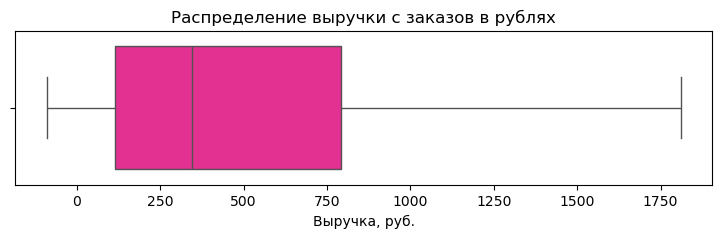

In [17]:
# Создаём контейнер для графика и задаём размер области вывода
plt.figure(figsize=(9, 2))

# Строим boxplot (ящик с усами) для столбца revenue
sns.boxplot(data=rub_df, x='revenue', color='deeppink', showfliers=False)

# Настраиваем оформление графика
plt.xlabel('Выручка, руб.')
plt.title('Распределение выручки с заказов в рублях')

# Выводим график
plt.show()

**Результаты:**
 - Объём данных: 285 542 заказа.
 - Средняя выручка: около 548 руб., медиана — 346,6 руб., что указывает на скошенность распределения вправо.
 - Разброс значений: стандартное отклонение 871,8 руб., минимум –90,8 руб., максимум 81 175 руб.
 - Отрицательные значения могут отражать возвраты или технические ошибки. Такие значения нужно обработать отдельно — либо исключить, либо учесть как корректировки.
 - Выбросы: большая часть заказов — это билеты до 800 руб., но редкие дорогие покупки тянут распределение вверх. 

Для корректного анализа выручки необходимо ограничить данные 99-м процентилем и далее работать с очищенным промежутком значений.

In [18]:
# Находим 99-й перцентиль для revenue в рублях
q99_rub = rub_df['revenue'].quantile(0.99)

In [19]:
# Обрезаем экстремальные значения выше 99-го перцентиля
rub_df_filtered = rub_df[rub_df['revenue'] <= q99_rub].copy()

In [20]:
# Выводим результаты
print(f"99-й перцентиль выручки: {q99_rub:.1f} руб.")
print(f"Количество удалённых строк: {rub_df.shape[0] - rub_df_filtered.shape[0]}")

99-й перцентиль выручки: 2570.8 руб.
Количество удалённых строк: 2800


Рассчитаем число заказов, у которых выручка отрицательная, и суммарную величину отрицательной выручки.

In [21]:
# Количество заказов с отрицательной выручкой
neg_count = rub_df_filtered[rub_df_filtered['revenue'] < 0].shape[0]

In [22]:
# Суммарная отрицательная выручка
neg_sum = rub_df_filtered[rub_df_filtered['revenue'] < 0]['revenue'].sum()

In [23]:
# Выводим результаты
print(f"Количество заказов с отрицательной выручкой: {neg_count}")
print(f"Сумма отрицательной выручки: {neg_sum}")

Количество заказов с отрицательной выручкой: 381
Сумма отрицательной выручки: -949.59


381 заказов были возвратами на общую сумму 950 руб. Поскольку исследование направлено на анализ покупок, а не возвратов, строки с отрицательной выручкой исключим из набора данных.

In [24]:
# Сохраняем исходный размер датафрейма
neg_row_count = rub_df_filtered.shape[0]

# Исключаем строки с отрицательной выручкой
rub_df_filtered = rub_df_filtered[rub_df_filtered['revenue'] >= 0].copy()

In [25]:
# Выводим результаты
print(f"Количество удалённых строк с отрицательной выручкой: {neg_row_count - rub_df_filtered.shape[0]}")
print(f"Количество строк в датафрейме после фильтраций: {rub_df_filtered.shape[0]}")

Количество удалённых строк с отрицательной выручкой: 381
Количество строк в датафрейме после фильтраций: 282361


Оценим ститистические показатели столбца `revenue` в тенге, используя метод describe().

In [26]:
# Изучаем статистические показатели столбца revenue в тенге
kzt_df['revenue'].describe()

count     5069.000000
mean      4995.206767
std       4916.752776
min          0.000000
25%        518.100000
50%       3698.830000
75%       7397.660000
max      26425.860000
Name: revenue, dtype: float64

Для наглядного отображения распределения выручки с заказов построим диаграмму размаха (boxplot).

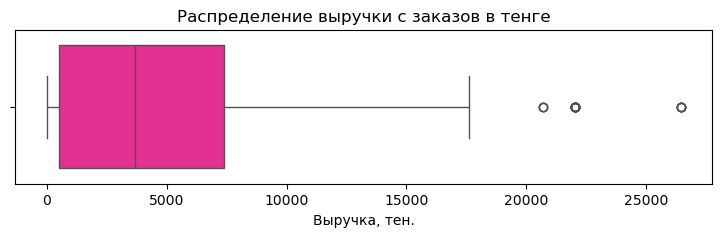

In [27]:
# Создаём контейнер для графика и задаём размер области вывода
plt.figure(figsize=(9, 2))

# Строим boxplot (ящик с усами) для столбца revenue
sns.boxplot(data=kzt_df, x='revenue', color='deeppink')

# Настраиваем оформление графика
plt.xlabel('Выручка, тен.')
plt.title('Распределение выручки с заказов в тенге')

# Выводим график
plt.show()

In [28]:
# Сохраняем исходный размер датафрейма
row_count_kzt = kzt_df.shape[0]

In [29]:
# Количество заказов с нулевой выручкой
zero_revenue_count = kzt_df[kzt_df['revenue'] == 0].shape[0]

print(f"Количество заказов с нулевой выручкой: {zero_revenue_count}")

Количество заказов с нулевой выручкой: 6


In [30]:
# Исключаем строки с нулевой выручкой
kzt_df = kzt_df[kzt_df['revenue'] > 0].copy()

In [31]:
# Находим 99-й перцентиль для revenue в тенге
q99_kzt = kzt_df['revenue'].quantile(0.99)

In [32]:
# Обрезаем экстремальные значения выше 99-го перцентиля
kzt_df = kzt_df[kzt_df['revenue'] <= q99_kzt].copy()

In [33]:
# Выводим результаты
print(f"99-й перцентиль выручки: {q99_kzt:.1f} тенге")
print(f"Количество удалённых строк: {row_count_kzt - kzt_df.shape[0]}")
print(f"Количество строк в датафрейме после фильтраций: {kzt_df.shape[0]}")

99-й перцентиль выручки: 17617.2 тенге
Количество удалённых строк: 35
Количество строк в датафрейме после фильтраций: 5034


Объединим данные в единую таблицу.

In [34]:
# Объединяем данные
afisha_df = pd.concat([rub_df_filtered, kzt_df], ignore_index=True)

# Выполним проверку
print("\nРазмер объединённого очищенного датафрейма:", afisha_df.shape)
afisha_df.head()


Размер объединённого очищенного датафрейма: (287395, 24)


,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6"
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,...,40efeb04-81b7-4135-b41f-708ff00cc64c,событие,выставки,№4850,Каменевский регион,Глиногорск,213,2941,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4"
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,...,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,цирковое шоу,другое,№1540,Каменевский регион,Глиногорск,213,4507,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6"
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,...,2f638715-8844-466c-b43f-378a627c419f,выставка,другое,№5049,Североярская область,Озёрск,2,3574,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8"
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,...,10d805d3-9809-4d8a-834e-225b7d03f95d,шоу,стендап,№832,Озернинский край,Родниковецк,240,1896,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8"


Оценим ститистические показатели столбца `tickets_count`, используя метод describe().

In [35]:
# Изучаем статистические показатели столбца tickets_count
afisha_df['tickets_count'].describe()

count    287395.000000
mean          2.741057
std           1.162492
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max          57.000000
Name: tickets_count, dtype: float64

Для наглядного отображения распределения количества билетов в заказах построим диаграмму размаха (boxplot), при этом выбросы на графике отключим, чтобы лучше видеть детали.

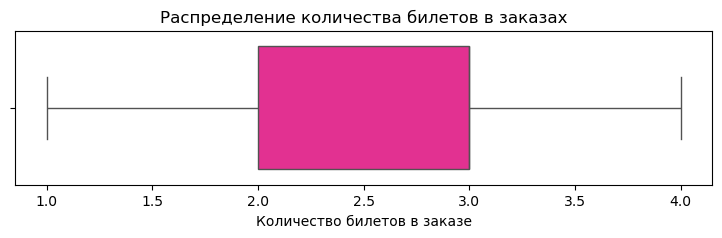

In [36]:
# Создаём контейнер для графика и задаём размер области вывода
plt.figure(figsize=(9, 2))

# Строим boxplot (ящик с усами) для столбца tickets_count
sns.boxplot(data=afisha_df, x='tickets_count', color='deeppink', showfliers=False)

# Настраиваем оформление графика
plt.xlabel('Количество билетов в заказе')
plt.title('Распределение количества билетов в заказах')

# Выводим график
plt.show()

**Результаты:**
 - Объём данных: 287 395 заказа.
 - Среднее количество билетов в заказе: около 2,74, медиана — 3, что указывает на то, что большинство заказов небольшие.
 - Разброс значений: стандартное отклонение 1,16 билета, минимум — 1, максимум — 57 билетов.
 - Заказы на 10–50 билетов — это групповые покупки (классы, корпоративы). Выбросы отражают реальное распределение и не являются аномалиями, которые нужно удалять.

### Явные и неявные дубликаты в данных

 - Выполним проверку на наличие полных дубликатов записей.

In [37]:
# Проверяем полные дубликаты в afisha_df
print(f"Полных дубликатов в датафрейме afisha_df: {afisha_df.duplicated().sum()}")

Полных дубликатов в датафрейме afisha_df: 0


В датафрейме нет полных дубликатов строк. 

 - Проанализируем возможные неявные дубликаты в информации о бронированиях, исключив учёт идентификаторов заказов.

In [38]:
# Формируем список колонок для проверки (все, кроме order_id)
dup_cols = [col for col in afisha_df.columns if col != 'order_id']

# Поиск неявных дубликатов с помощью метода duplicated() 
duplicates = afisha_df[afisha_df.duplicated(subset=dup_cols, keep=False)]

In [39]:
# Выведем результаты
print(f"Неявных дубликатов: {duplicates.shape[0]}")
duplicates[['order_id'] + dup_cols].sort_values(dup_cols).head(4)

Неявных дубликатов: 58


,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
11474,1123983,06eb7897f65b433,2024-08-13,2024-08-13 16:31:07,183706,нет,18,rub,mobile,69.82,...,69796237-909b-42a7-bfb5-c1b8574c4c76,спектакль,театр,№1482,Светополянский округ,Глиноград,54,4443,"Центр культурного наследия ""Объединение"" и пар...","бул. Карбышева, д. 50"
11475,1123867,06eb7897f65b433,2024-08-13,2024-08-13 16:31:07,183706,нет,18,rub,mobile,69.82,...,69796237-909b-42a7-bfb5-c1b8574c4c76,спектакль,театр,№1482,Светополянский округ,Глиноград,54,4443,"Центр культурного наследия ""Объединение"" и пар...","бул. Карбышева, д. 50"
55737,160922,2564e3703075008,2024-10-30,2024-10-30 10:04:15,589005,нет,6,rub,mobile,11.23,...,bee8d0cc-282b-492e-9ed8-ec0990f43ffd,выставка,другое,№1810,Яблоневская область,Горяново,11036,1656,"Модная академия ""Пункт"" Лимитед","бул. Гагарина, д. 39"
55740,160893,2564e3703075008,2024-10-30,2024-10-30 10:04:15,589005,нет,6,rub,mobile,11.23,...,bee8d0cc-282b-492e-9ed8-ec0990f43ffd,выставка,другое,№1810,Яблоневская область,Горяново,11036,1656,"Модная академия ""Пункт"" Лимитед","бул. Гагарина, д. 39"


В результате проверки было найдено 58 неявных дубликатов. Эти строки полностью совпадают по всем ключевым характеристикам заказа — пользователю, событию, времени создания, количеству билетов, выручке, а также по информации о площадке и регионе. Отличается только идентификатор заказа.

Подобные записи искажают аналитику, поскольку приводят к двойному учёту одних и тех же заказов и завышению выручки. Удалим неявные дубликаты, оставляя по одной уникальной записи в каждой группе одинаковых строк.

In [40]:
# Сохраняем исходный размер датафрейма
row_count_with_dup = afisha_df.shape[0]

# Удаляем неявных дубликатов
afisha_df = afisha_df.drop_duplicates(subset=dup_cols, keep='first')

# Проверим результат
print(f"После удаления всех дубликатов осталось строк: {len(afisha_df)}")
print(f"Разница строк: {row_count_with_dup - len(afisha_df)}")

После удаления всех дубликатов осталось строк: 287365
Разница строк: 30


### Типы данных

Произведем корректировку типов данных.

 - Преобразование столбцов с датами/временем.

In [41]:
# Приводим к datetime
for col in ['created_dt_msk', 'created_ts_msk']:
    if col in afisha_df.columns:
        afisha_df[col] = pd.to_datetime(afisha_df[col], errors='coerce')

In [42]:
tenge_df['data'] = pd.to_datetime(tenge_df['data'])

 - Оптимизация строковых столбцов.

In [43]:
# Приводим к category
for col in ['cinema_circuit', 'currency_code', 'device_type_canonical', 'service_name',
    'event_type_description', 'event_type_main', 'organizers',
    'region_name', 'city_name', 'venue_name', 'venue_address']:
    if col in afisha_df.columns:
        afisha_df[col] = afisha_df[col].astype('category')

 - Оптимизация числовых типов.

In [44]:
# Приводим к float32
for col in ['revenue', 'total', 'days_since_prev']:
    if col in afisha_df.columns:
        afisha_df[col] = afisha_df[col].astype('float32')

In [45]:
# Приводим к int8
afisha_df['age_limit'] = afisha_df['age_limit'].astype('int8')

In [46]:
# Приводим к int16
afisha_df['tickets_count'] = afisha_df['tickets_count'].astype('int16')

In [47]:
# Приводим к int32
for col in ['order_id', 'event_id', 'venue_id', 'city_id']:
    if col in afisha_df.columns:
        afisha_df[col] = afisha_df[col].astype('int32')

In [48]:
# Выполним проверку
afisha_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 287365 entries, 0 to 287394
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                287365 non-null  int32         
 1   user_id                 287365 non-null  object        
 2   created_dt_msk          287365 non-null  datetime64[ns]
 3   created_ts_msk          287365 non-null  datetime64[ns]
 4   event_id                287365 non-null  int32         
 5   cinema_circuit          287365 non-null  category      
 6   age_limit               287365 non-null  int8          
 7   currency_code           287365 non-null  category      
 8   device_type_canonical   287365 non-null  category      
 9   revenue                 287365 non-null  float32       
 10  service_name            287365 non-null  category      
 11  tickets_count           287365 non-null  int16         
 12  total                   287365 non-

### Конвертация валюты

Создадим показатель `revenue_rub`, пересчитав выручку в рубли. Для конвертации применим таблицу с курсом тенге к рублю `final_tickets_tenge_df.csv` за 2024 год, где значения приведены за 100 тенге.

In [49]:
# Найдем курс одного тенге в рублях
tenge_df['rate_tenge_rub'] = tenge_df['curs'] / tenge_df['nominal']

In [50]:
# Выполним объединение данных по датам
afisha_df = afisha_df.merge(tenge_df[['data', 'rate_tenge_rub']], left_on='created_dt_msk', right_on='data', how='left')

In [51]:
# Удаляем временный столбец data
afisha_df.drop(columns=['data'], inplace=True)

In [52]:
# Сначала копируем выручку в рублях как базовое значение
afisha_df['revenue_rub'] = afisha_df['revenue'] 

In [53]:
# Маска для заказов в тенге
mask = afisha_df['currency_code'] == 'KZT'

# Пересчитываем только строки в тенге
afisha_df.loc[mask, 'revenue_rub'] = afisha_df.loc[mask, 'revenue'] * afisha_df.loc[mask, 'rate_tenge_rub']

In [54]:
# Выполним проверку
afisha_df[['currency_code', 'revenue', 'rate_tenge_rub', 'revenue_rub']].head()

,currency_code,revenue,rate_tenge_rub,revenue_rub
0,rub,1521.939941,0.186972,1521.939941
1,rub,289.450012,0.183419,289.450012
2,rub,1258.569946,0.196475,1258.569946
3,rub,8.490000,0.185010,8.490000
4,rub,1390.410034,0.196648,1390.410034


### Формирование новых показателей

 - Столбец `one_ticket_revenue_rub` — выручка с продажи одного билета на мероприятие в рублях.

In [55]:
# Выручка с продажи одного билета
afisha_df['one_ticket_revenue_rub'] = afisha_df['revenue_rub'] / afisha_df['tickets_count']

In [56]:
# Выполним проверку
afisha_df[['revenue_rub', 'tickets_count', 'one_ticket_revenue_rub']].head()

,revenue_rub,tickets_count,one_ticket_revenue_rub
0,1521.939941,4,380.484985
1,289.450012,2,144.725006
2,1258.569946,4,314.642487
3,8.490000,2,4.245000
4,1390.410034,3,463.470001


 - Столбец `month` — месяц оформления заказа (для анализа сезонных трендов).

In [57]:
# Выделяем месяц 
afisha_df['month'] = afisha_df['created_dt_msk'].dt.month

 - Столбец `season` — столбец с информацией о сезонности: лето, осень, зима, весна.

In [58]:
# Создаём функцию деления по сезонам
def assign_season(month):
    if month in [12, 1, 2]:
        return 'зима'
    elif month in [3, 4, 5]:
        return 'весна'
    elif month in [6, 7, 8]:
        return 'лето'
    else:
        return 'осень'

# Создаём столбец с сезоном, используя функцию
afisha_df['season'] = afisha_df['month'].apply(assign_season)

In [59]:
# Выполним проверку
afisha_df[['created_dt_msk', 'month', 'season']].head()

,created_dt_msk,month,season
0,2024-08-20,8,лето
1,2024-07-23,7,лето
2,2024-10-06,10,осень
3,2024-07-13,7,лето
4,2024-10-04,10,осень


### Промежуточный вывод

На данном этапе были выполнены следующие действия:

 - Данные из разных датасетов были объединены в единый датафрейм для дальнейшего анализа.
 - Проведена проверка пропусков.
 - Изучены количественные признаки: проведён анализ распределений выручки и количества билетов в заказах, выбросы в выручке ограничены 99-м перцентилем.
 - Удалены заказы с отрицательной выручкой в рублях и нулевые заказы в тенге.
 - Проведена проверка явных и неявных дубликатов, в результате удалено 30 неявных повторов заказов.
 - Выполнено преобразование типов данных, включая корректное приведение временных столбцов к формату datetime.
 - Добавлен столбец `revenue_rub`, в котором вся выручка пересчитана в единую валюту — российские рубли.
 - Добавлены новые показатели: `one_ticket_revenue_rub`, `month`, `season`.

<a class = "anchor" id = "3-da" ><a/>
## Исследовательский анализ данных

### Анализ распределения заказов по сегментам и их сезонные изменения

Изучим распределение заказов по сегментам и их сезонные изменения.

 - Для каждого месяца найдём количество заказов и визуализируем результаты. 

In [60]:
# Группируем по месяцам
monthly_orders = afisha_df.groupby('month', observed=True).agg(total_orders=('order_id', 'count')).reset_index()

In [61]:
# Добавляем названия месяцев
month_names = {
    6: "Июнь",
    7: "Июль",
    8: "Август",
    9: "Сентябрь",
    10: "Октябрь"}
monthly_orders["month_name"] = monthly_orders["month"].map(month_names)

In [62]:
# Выводим таблицу
monthly_orders

,month,total_orders,month_name
0,6,34056,Июнь
1,7,40361,Июль
2,8,44525,Август
3,9,69264,Сентябрь
4,10,99159,Октябрь


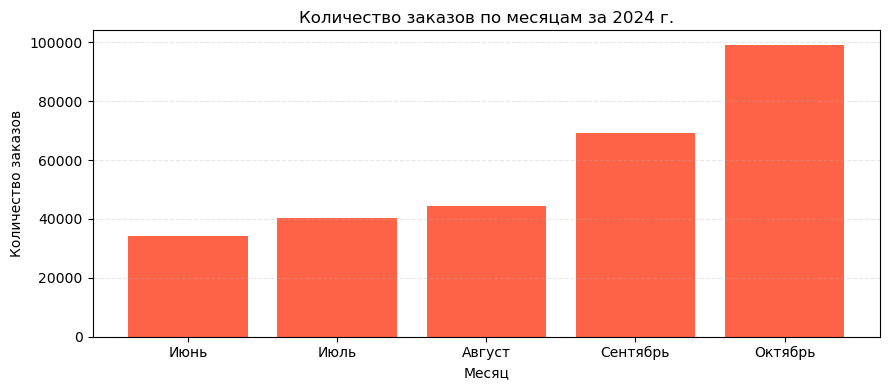

In [63]:
# Создаём контейнер для графика и задаём размер области вывода
plt.figure(figsize=(9,4))

# Строим столбчатую диаграмму
plt.bar(monthly_orders["month_name"], monthly_orders["total_orders"], color='tomato')

# Настраиваем оформление графика
plt.title("Количество заказов по месяцам за 2024 г.")
plt.xlabel("Месяц")
plt.ylabel("Количество заказов")
plt.grid(axis="y", linestyle="--", alpha=0.3)

# Выводим график
plt.tight_layout()
plt.show()

**Результаты:**
 - Пользовательская активность выраженно возрастает с конца лета, достигая пика в октябре.
 - Вероятные причины: увеличение числа мероприятий, окончание отпусков, возвращение аудитории в город, усиление маркетинговой активности, рост популярности мероприятий в помещениях при ухудшении погоды.

 - Для осеннего и летнего периодов сравним распределение заказов билетов по типам мероприятий.

In [64]:
# Рассчитаем число заказов по каждому типу мероприятия
season_events = afisha_df.groupby(['season', 'event_type_main'], observed=True).agg(total_orders=('order_id', 'count')).reset_index()

In [65]:
# Рассчитаем суммарный объём заказов по сезонам
season_totals = season_events.groupby('season').agg(season_total=('total_orders', 'sum')).reset_index()

In [66]:
# Добавляем общие суммы к таблице
season_events = season_events.merge(season_totals, on='season')

In [67]:
# Рассччитаем долю заказов по каждому типу мероприятия в рамках сезона
season_events['share'] = round(season_events['total_orders'] / season_events['season_total'],3)

In [68]:
# Подготовим таблицу для графика
pivot_df_events = season_events.pivot(
    index='event_type_main',
    columns='season',
    values='share')

# Выводим таблицу на экран
display(pivot_df_events)

season,лето,осень
event_type_main,,
выставки,0.020,0.014
другое,0.271,0.196
концерты,0.427,0.373
спорт,0.025,0.112
стендап,0.053,0.041
театр,0.201,0.254
ёлки,0.002,0.010


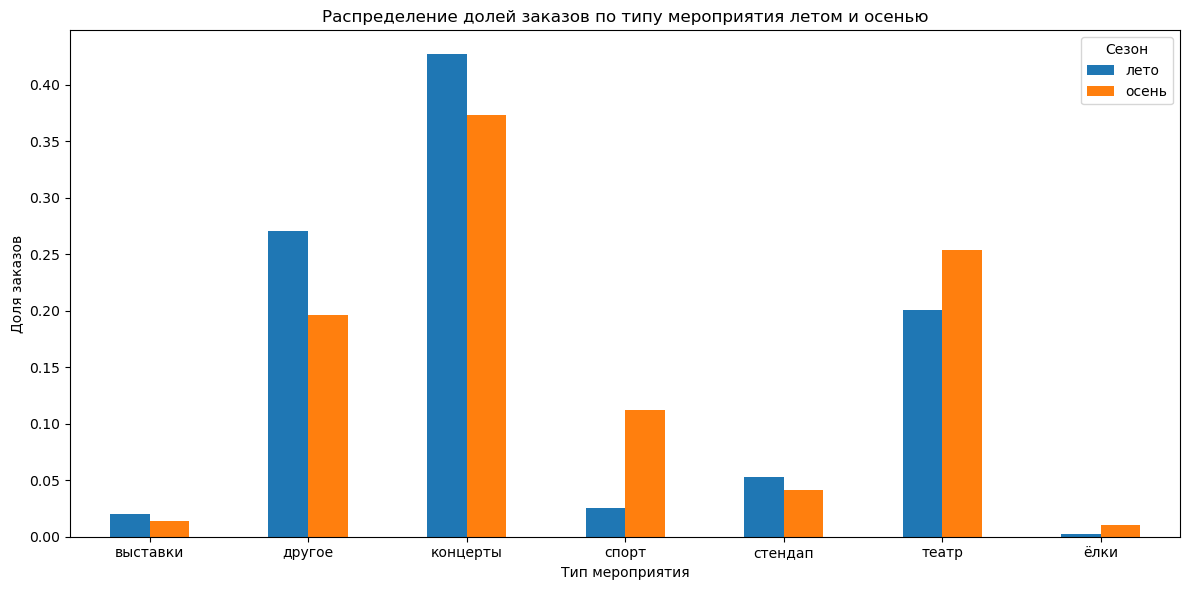

In [69]:
# Cтроим столбчатую диаграмму
pivot_df_events.plot(kind='bar', figsize=(12, 6))

# Настраиваем оформление графика
plt.title('Распределение долей заказов по типу мероприятия летом и осенью')
plt.ylabel("Доля заказов")
plt.xlabel("Тип мероприятия")
plt.xticks(rotation=0)
plt.legend(title="Сезон")

# Выводим график
plt.tight_layout()
plt.show()

**Результаты:**
- Концерты: самая крупная категория в оба сезона, но осенью её доля немного снижается.
- Театр: осенью доля театральных мероприятий заметно растёт.
- Спорт: доля спортивных мероприятий увеличивается в несколько раз благодаря началу спортивных сезонов.
- Другое: доля снижается, так как летом больше разноплановых событий.
- Выставки: спрос почти не меняется, небольшое снижение осенью.
- Стендап: лёгкое снижение доли осенью, но категория остаётся популярной.
- Ёлки: ожидаемый рост в осенний период — начинается ранняя покупка новогодних мероприятий.

**Вывод:** осенью структура интереса смещается в сторону театра, спорта и праздничных мероприятий, доля концертов и разноплановых событий снижается.

 - Для осеннего и летнего периодов сравним распределение заказов билетов по типам устройств.

In [70]:
# Рассчитаем число заказов по каждому типу устройства
season_device = afisha_df.groupby(['season', 'device_type_canonical'], observed=True).agg(total_orders=('order_id', 'count')).reset_index()

In [71]:
# Добавляем общие суммы к таблице
season_device = season_device.merge(season_totals, on='season')

In [72]:
# Рассччитаем долю заказов по каждому типу устройства в рамках сезона
season_device['share'] = round(season_device['total_orders'] / season_device['season_total'],3)

In [73]:
# Подготовим таблицу для графика
pivot_df_device = season_device.pivot(
    index='device_type_canonical',
    columns='season',
    values='share')

# Выводим таблицу на экран
display(pivot_df_device)

season,лето,осень
device_type_canonical,,
desktop,0.194,0.204
mobile,0.806,0.796


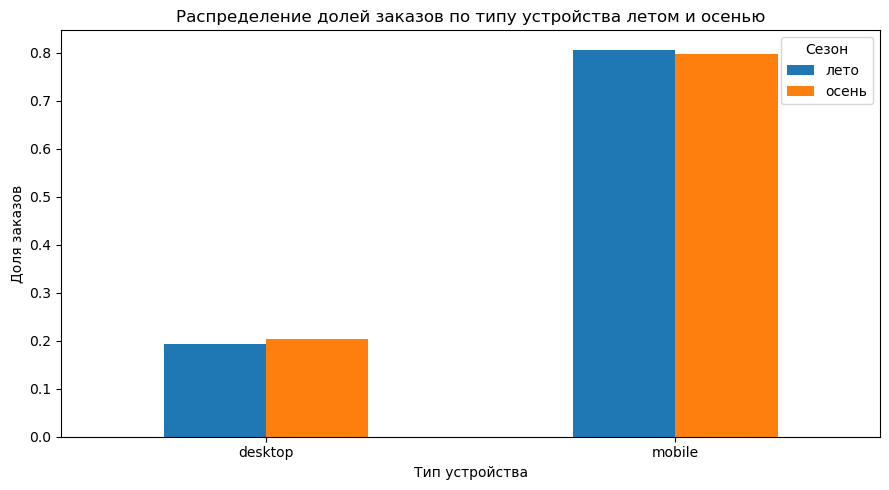

In [74]:
# Cтроим столбчатую диаграмму
pivot_df_device.plot(kind='bar', figsize=(9, 5))

# Настраиваем оформление графика
plt.title('Распределение долей заказов по типу устройства летом и осенью')
plt.ylabel("Доля заказов")
plt.xlabel("Тип устройства")
plt.xticks(rotation=0)
plt.legend(title="Сезон")

# Выводим график
plt.tight_layout()
plt.show()

**Результат:**
 - Mobile: доминирующий канал заказов в обоих сезонах (лето — 80,6%, осень — 79,6%).
 - Desktop: небольшой рост доли осенью (лето — 19,4%, осень — 20,4%).

**Вывод:** Структура устройств стабильна, мобильные устройства лидируют, осенью небольшое смещение в сторону desktop.

 - Для осеннего и летнего периодов сравним распределение заказов билетов по возрастному рейтингу мероприятий.

In [75]:
# Рассчитаем число заказов по каждому типу возрастного рейтинга
season_age = afisha_df.groupby(['season', 'age_limit'], observed=True).agg(total_orders=('order_id', 'count')).reset_index()

In [76]:
# Добавляем общие суммы к таблице
season_age = season_age.merge(season_totals, on='season')

In [77]:
# Рассчитаем долю заказов по каждому типу возрастного рейтинга в рамках сезона
season_age['share'] = round(season_age['total_orders'] / season_age['season_total'],3)

In [78]:
# Подготовим таблицу для графика
pivot_df_age = season_age.pivot(
    index='age_limit',
    columns='season',
    values='share')

# Выводим таблицу на экран
display(pivot_df_age)

season,лето,осень
age_limit,,
0,0.179,0.236
6,0.182,0.176
12,0.205,0.221
16,0.284,0.262
18,0.150,0.104


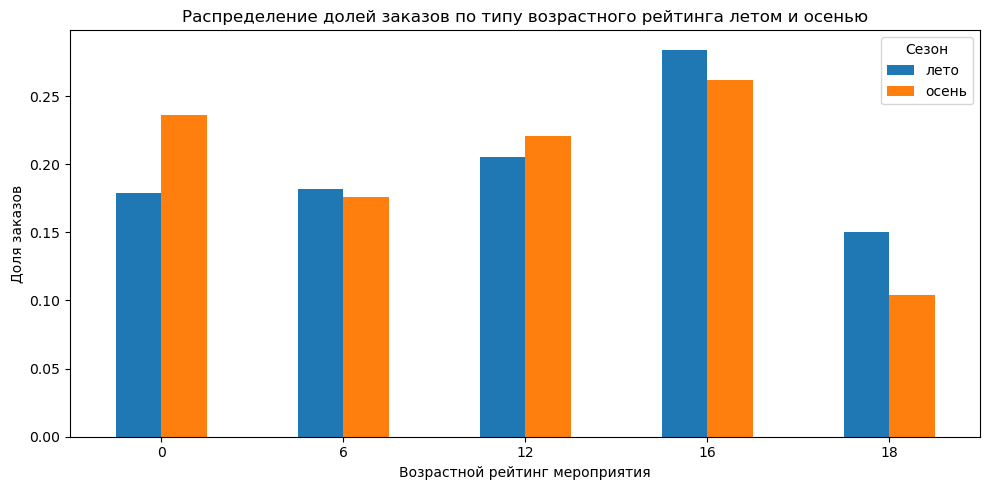

In [79]:
# Cтроим столбчатую диаграмму
pivot_df_age.plot(kind='bar', figsize=(10, 5))

# Настраиваем оформление графика
plt.title('Распределение долей заказов по типу возрастного рейтинга летом и осенью')
plt.ylabel("Доля заказов")
plt.xlabel("Возрастной рейтинг мероприятия")
plt.xticks(rotation=0)
plt.legend(title="Сезон")

# Выводим график
plt.tight_layout()
plt.show()

**Результаты:**
 - 0+ и 12+: доля заказов увеличилась осенью (0+ с 17,9% до 23,6%, 12+ с 20,5% до 22,1%), что указывает на рост интереса к мероприятиям для младших и средних возрастов.
 - 16+ и 18+: доля заказов снизилась осенью (16+ с 28,4% до 26,2%, 18+ с 15% до 10,4%), возможно, снижение активности взрослых и старшей аудитории.
 - 6+: доля практически не изменилась.

**Вывод:** Осенью больше заказов приходится на младшую и среднюю аудиторию, доля старших возрастов сокращается.

 - Проанализируем изменение выручки с продажи одного билета в зависимости от типа мероприятия летом и осенью. 

In [80]:
# Группировка по сезону и типу мероприятия
ticket_revenue_summary = afisha_df.groupby(['season', 'event_type_main'], observed=True).agg(mean_ticket_revenue=('one_ticket_revenue_rub', 'mean')).reset_index()

In [81]:
# Подготовим таблицу для графика
pivot_df = ticket_revenue_summary.pivot(
    index='event_type_main',
    columns='season',
    values='mean_ticket_revenue')

In [82]:
# Расчёт относительного изменения осень/лето
pivot_df['change_%'] = ((pivot_df['осень'] - pivot_df['лето']) / pivot_df['лето'] * 100).round(2)

In [83]:
# Выводим таблицу на экран
display(pivot_df)

season,лето,осень,change_%
event_type_main,,,
выставки,86.744476,91.905090,5.950000
другое,82.404366,80.833199,-1.910000
концерты,430.674133,279.105042,-35.189999
спорт,55.228008,53.982403,-2.260000
стендап,219.073151,231.124985,5.500000
театр,214.194122,175.969513,-17.850000
ёлки,271.436188,229.585587,-15.420000


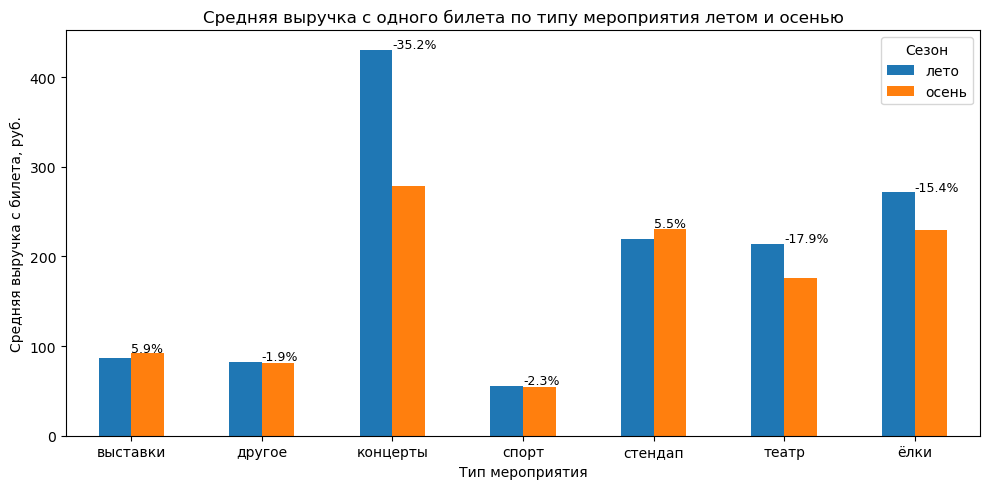

In [84]:
# Cтроим столбчатую диаграмму
pivot_df[['лето', 'осень']].plot(kind='bar', figsize=(10,5))

# Настраиваем оформление графика
plt.title("Средняя выручка с одного билета по типу мероприятия летом и осенью")
plt.ylabel("Средняя выручка с билета, руб.")
plt.xlabel("Тип мероприятия")
plt.xticks(rotation=0)
plt.legend(title="Сезон")

# Отображение относительного изменения над столбцами
for i, change in enumerate(pivot_df['change_%']):
    plt.text(i, max(pivot_df.iloc[i, :2]) + 2, f'{change:.1f}%', ha='left', fontsize=9)

# Выводим график
plt.tight_layout()
plt.show()

**Результат:**
 - Рост: выставки (+5,9%) и стендап (+5,5%) — билеты стали дороже или выбираются более дорогие места.
 - Снижение: концерты (-35,2%), театр (-17,9%), ёлки (-15,4%) — пользователи покупают более дешёвые билеты или проходят акции.
 - Стабильные категории: другое (-1,9%) и спорт (-2,3%).

**Вывод:** средняя выручка зависит от типа мероприятия, осенью пользователи тратят меньше на концерты и театр, но немного больше на выставки и стендап.

**Промежуточный вывод**

Осенний сезон характеризуется ростом пользовательской активности и количества заказов, перераспределением интереса в пользу театра, спорта, праздничных мероприятий и мероприятий для младшей и средней аудитории. Структура устройств практически не меняется, мобильные заказы остаются доминирующими. Средняя выручка с билета демонстрирует значительную зависимость от типа мероприятия: часть категорий становится дороже, часть дешевле, что отражает сезонные изменения спроса и покупательской стратегии пользователей.

### Осенняя активность пользователей

Рассмотрим пользовательскую активность в осенний период, используя данные за сентябрь и октябрь 2024 года.

 - Проанализируем динамику изменений по дням для:
    - общего числа заказов;
    - количества активных пользователей DAU;
    - среднего числа заказов на одного пользователя;
    - средней стоимости одного билета.

In [85]:
# Выделим только осенний период (сентябрь и октябрь)
afisha_df_autumn = afisha_df[afisha_df['season'] == 'осень'].copy()

In [86]:
# Сформируем ежедневную сводную таблицу
daily = afisha_df_autumn.groupby('created_dt_msk').agg(
        orders_count = ('order_id', 'count'),                # общее число заказов
        dau = ('user_id', 'nunique'),                        # число уникальных пользователей (DAU)
        mean_one_ticket = ('one_ticket_revenue_rub', 'mean') # средняя стоимость 1 билета (руб.)
    ).sort_index()

In [87]:
# Рассчитаем среднее число заказов на одного пользователя 
daily['orders_per_user'] = round(daily['orders_count'] / daily['dau'],2)

In [88]:
# Выводим таблицу
display(daily.head())

,orders_count,dau,mean_one_ticket,orders_per_user
created_dt_msk,,,,
2024-09-01,1327,564,202.947678,2.35
2024-09-02,1376,573,209.758789,2.40
2024-09-03,5094,777,86.111610,6.56
2024-09-04,1760,684,204.919693,2.57
2024-09-05,1941,738,215.732101,2.63


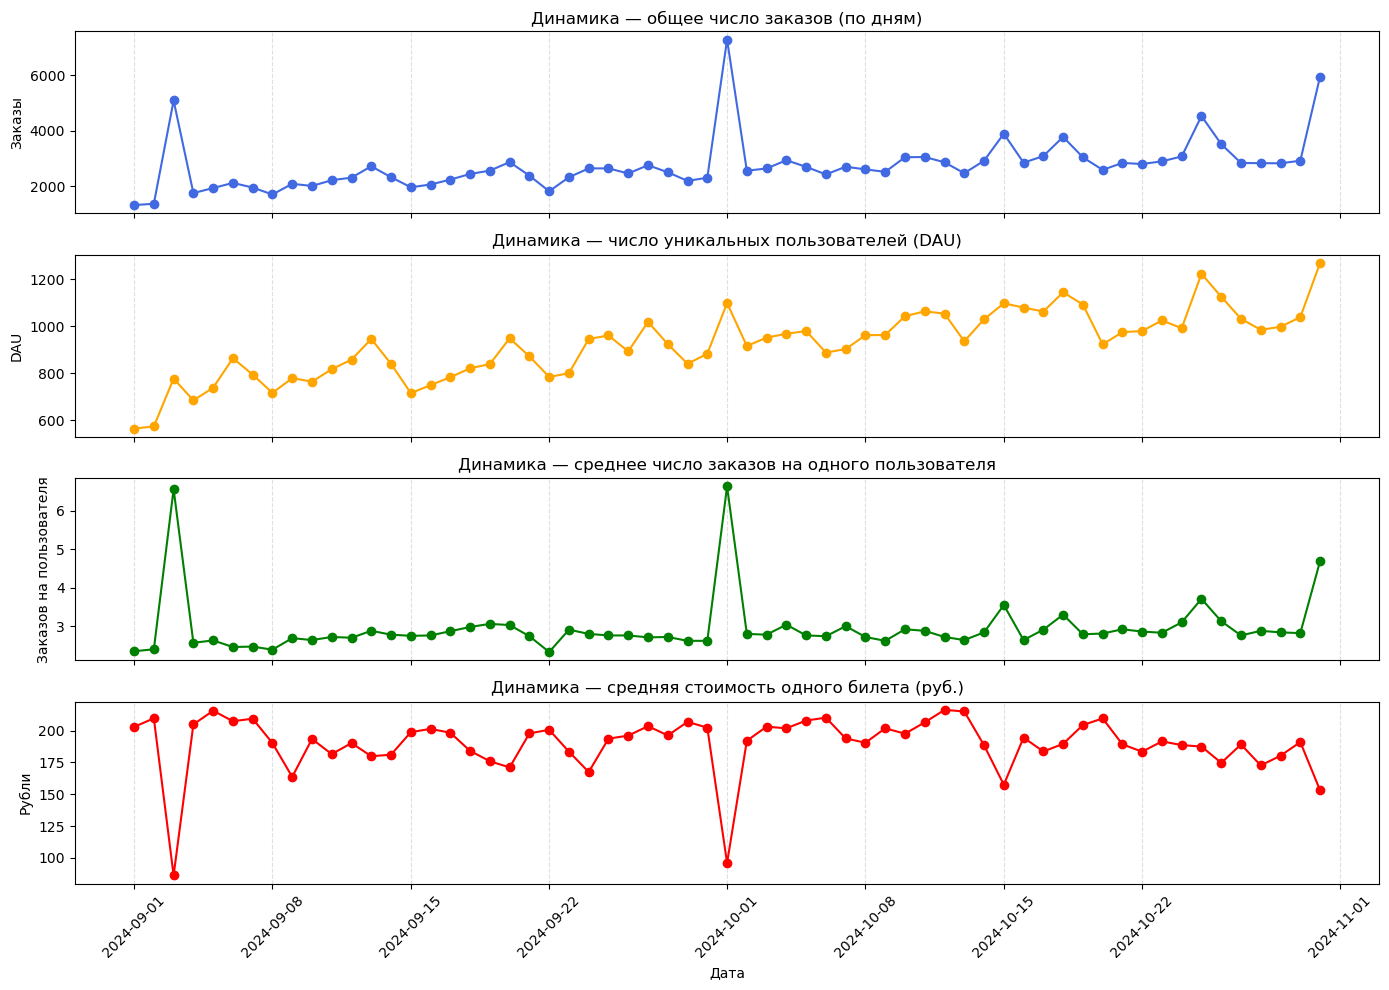

In [89]:
# Создаём контейнер для графиков и задаём размер области вывода
fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

# Строим линейные графики
# 1 — общее число заказов
axes[0].plot(daily.index, daily['orders_count'], linestyle='-', marker='o', color='royalblue')
axes[0].set_title('Динамика — общее число заказов (по дням)')
axes[0].set_ylabel('Заказы')
axes[0].grid(True, axis='x', linestyle='--', alpha=0.4)

# 2 — DAU
axes[1].plot(daily.index, daily['dau'], linestyle='-', marker='o', color='orange')
axes[1].set_title('Динамика — число уникальных пользователей (DAU)')
axes[1].set_ylabel('DAU')
axes[1].grid(True, axis='x', linestyle='--', alpha=0.4)

# 3 — количество заказов на пользователя
axes[2].plot(daily.index, daily['orders_per_user'], linestyle='-', marker='o', color='green')
axes[2].set_title('Динамика — среднее число заказов на одного пользователя')
axes[2].set_ylabel('Заказов на пользователя')
axes[2].grid(True, axis='x', linestyle='--', alpha=0.4)

# 4 — средняя стоимость одного билета
axes[3].plot(daily.index, daily['mean_one_ticket'], linestyle='-', marker='o', color='red')
axes[3].set_title('Динамика — средняя стоимость одного билета (руб.)')
axes[3].set_ylabel('Рубли')
axes[3].set_xlabel('Дата')
axes[3].grid(True, axis='x', linestyle='--', alpha=0.4)

# Поворачиваем подписи дат
plt.xticks(rotation=45)

# Выводим график
plt.tight_layout()
plt.show()

**Результаты:**
 - Общее число заказов (orders_count) и количество уникальных пользователей (DAU) растёт с начала сентября к концу октября, что отражает сезонное увеличение интереса к мероприятиям.
 - Среднее число заказов на пользователя (orders_per_user) остаётся относительно стабильным в диапазоне 2,7–3,1, указывая на постоянное поведение аудитории.
 - Средний чек (mean_one_ticket) в целом стабилен (около 190–210 руб.), за исключением отдельных аномальных дней, таких как 3 сентября и 1 октября, где наблюдались резкие пики активности при низком среднем чеке, вероятно, из-за акций или массовых мероприятий с дешевыми билетами.

 - Проанализируем недельную цикличность: выделим день недели и сравним пользовательскую активность в будни и выходные.

Оценим как изменяются по дням недели следующие метрики: общее количество заказов, число уникальных активных пользователей (DAU), среднее количество заказов на пользователя и средняя стоимость одного билета. На основе полученных значений построим линейные графики.

In [90]:
# Добавляем столбец с днем недели
daily['weekday'] = daily.index.dayofweek  # где 0=Пн 

In [91]:
# Добавляем названия дней недели
weekday_map = {0: 'Пн', 1: 'Вт', 2: 'Ср', 3: 'Чт', 4: 'Пт', 5: 'Сб', 6: 'Вс'}
daily['weekday_name'] = daily['weekday'].map(weekday_map)

In [92]:
# Добавляем категорию: будни или выходные
daytype_map = {0: 'Будни', 1: 'Будни', 2: 'Будни', 3: 'Будни', 4: 'Будни', 5: 'Выходные', 6: 'Выходные'}
daily['day_type'] = daily['weekday'].map(daytype_map)

In [93]:
# Группируем по дням недели
weekday_summary = daily.groupby('weekday_name').agg({
        'orders_count': 'mean',
        'dau': 'mean',
        'orders_per_user': 'mean',
        'mean_one_ticket': 'mean'}).reindex(['Пн','Вт','Ср','Чт','Пт','Сб','Вс'])   # упорядочиваем

In [94]:
# Выводим таблицу
print("Средние показатели по дням недели:")
display(weekday_summary)

Средние показатели по дням недели:


,orders_count,dau,orders_per_user,mean_one_ticket
weekday_name,,,,
Пн,2388.555556,853.000000,2.780000,189.451462
Вт,3493.333333,934.111111,3.718889,161.462555
Ср,2539.333333,922.888889,2.748889,192.834503
Чт,3013.000000,960.888889,3.061111,189.362839
Пт,3101.375000,1022.375000,3.001250,193.444809
Сб,2666.125000,960.375000,2.763750,198.524475
Вс,2152.777778,822.000000,2.598889,202.653992


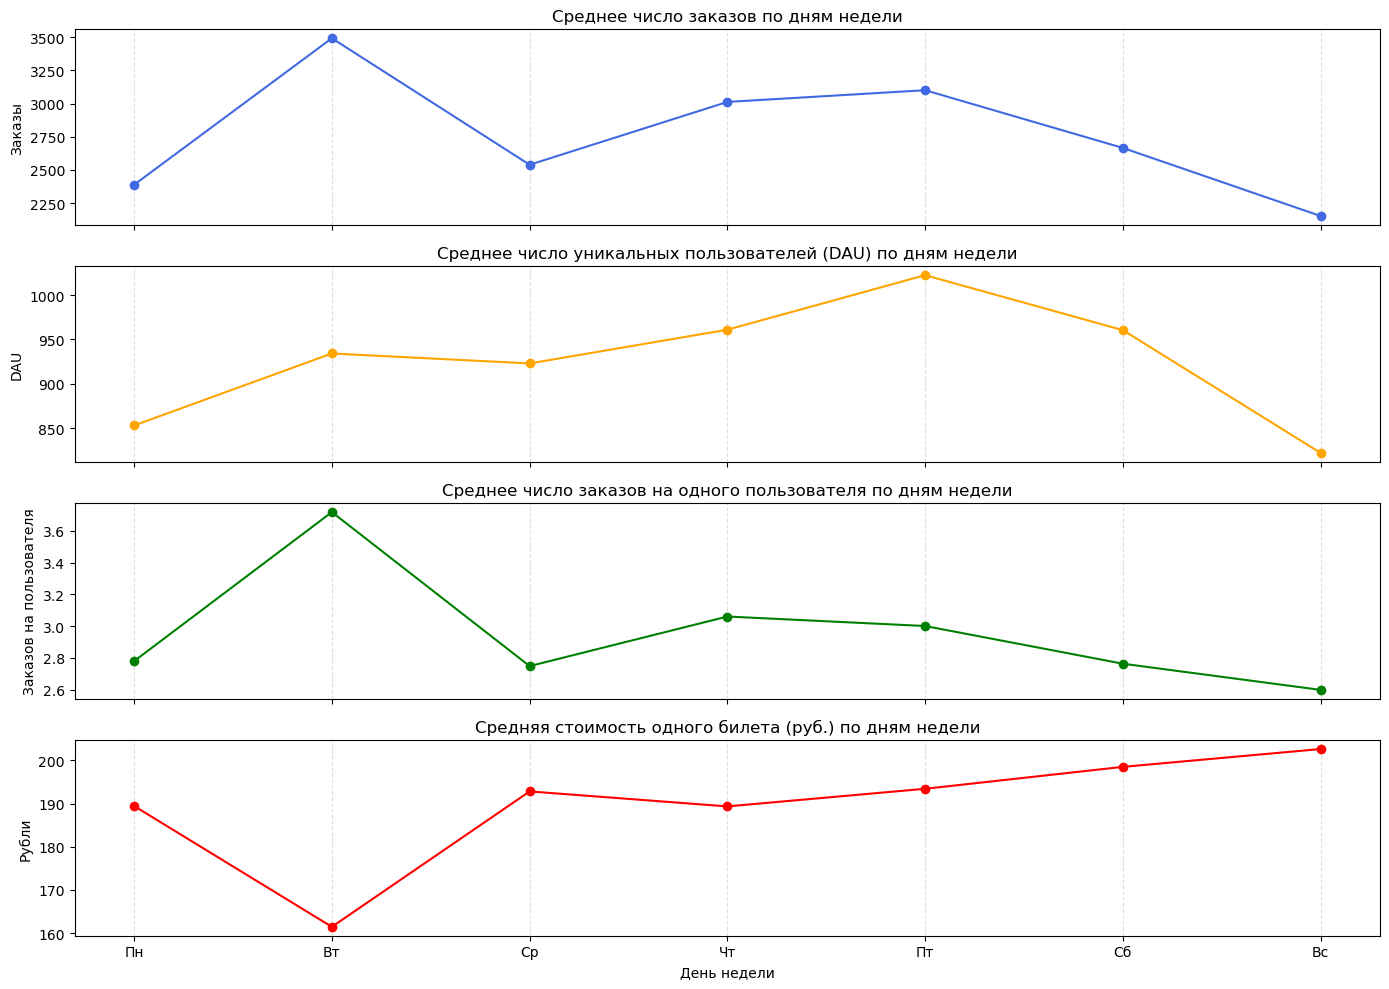

In [95]:
# Создаём контейнер для графиков и задаём размер области вывода
fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

# 1 — среднее число заказов
axes[0].plot(weekday_summary.index, weekday_summary['orders_count'], linestyle='-', marker='o', color='royalblue')
axes[0].set_title('Среднее число заказов по дням недели')
axes[0].set_ylabel('Заказы')
axes[0].grid(True, axis='x', linestyle='--', alpha=0.4)

# 2 — DAU
axes[1].plot(weekday_summary.index, weekday_summary['dau'], linestyle='-', marker='o', color='orange')
axes[1].set_title('Среднее число уникальных пользователей (DAU) по дням недели')
axes[1].set_ylabel('DAU')
axes[1].grid(True, axis='x', linestyle='--', alpha=0.4)

# 3 — среднее число заказов на пользователя
axes[2].plot(weekday_summary.index, weekday_summary['orders_per_user'], linestyle='-', marker='o', color='green')
axes[2].set_title('Среднее число заказов на одного пользователя по дням недели')
axes[2].set_ylabel('Заказов на пользователя')
axes[2].grid(True, axis='x', linestyle='--', alpha=0.4)

# 4 — средняя стоимость одного билета
axes[3].plot(weekday_summary.index, weekday_summary['mean_one_ticket'], linestyle='-', marker='o', color='red')
axes[3].set_title('Средняя стоимость одного билета (руб.) по дням недели')
axes[3].set_ylabel('Рубли')
axes[3].set_xlabel('День недели')
axes[3].grid(True, axis='x', linestyle='--', alpha=0.4)

# Выводим график
plt.tight_layout()
plt.show()


**Результаты:**
 - Наибольшая активность по количеству заказов наблюдается во вторник (3493) и пятницу (3101), наименьшая — в воскресенье (2153).
 - DAU максимален в пятницу (1022), минимален в воскресенье (822).
 - Среднее число заказов на пользователя выше в будние дни, особенно во вторник (3.72), и ниже в выходные.
 - Средняя стоимость билета выше в выходные (203 руб. в воскресенье) и ниже в будние дни (161–185 руб.), что указывает на выбор более дорогих мероприятий в выходные.

Рассчитаем среднее количество заказов и среднее число уникальных пользователей отдельно для будних и выходных дней. На основе полученных значений построим столбчатую диаграмму для наглядного сравнения.

In [96]:
# Группируем по типу дня: будни или выходные
daytype_summary = daily.groupby('day_type').agg({
        'orders_count': 'mean',
        'dau': 'mean',
        'orders_per_user': 'mean',
        'mean_one_ticket': 'mean'}).round(1)

In [97]:
# Выводим таблицу
display(daytype_summary)

,orders_count,dau,orders_per_user,mean_one_ticket
day_type,,,,
Будни,2902.7,936.8,3.1,185.100006
Выходные,2394.4,887.1,2.7,200.699997


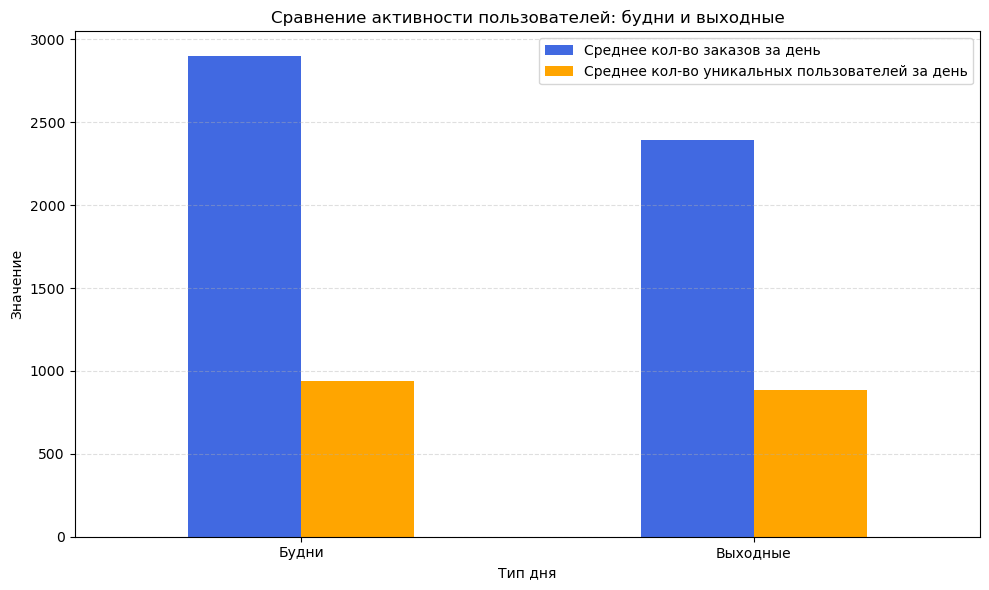

In [98]:
# Сбросим индекс
df_plot = daytype_summary.reset_index()

# Строим столбчатые диаграммы
df_plot.plot(
    x='day_type',
    y=['orders_count', 'dau'],
    kind='bar',
    figsize=(10,6),
    color=['royalblue', 'orange'])

# Настраиваем оформление графика
plt.xlabel('Тип дня')
plt.ylabel('Значение')
plt.title('Сравнение активности пользователей: будни и выходные')
plt.xticks(rotation=0)
plt.legend(['Среднее кол-во заказов за день', 'Среднее кол-во уникальных пользователей за день'])
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Выводим график
plt.tight_layout()
plt.show()

**Результаты:**
 - В будние дни совершается в среднем 2903 заказов, в выходные — 2394, т.е. активность падает примерно на 18%.
 - DAU в будние дни — 937, в выходные — 887, разница менее значительная (около 5%).
 - Среднее количество заказов на пользователя: будни — 3.1, выходные — 2.7.
 - Средний чек выше в выходные (201 руб.) по сравнению с будними днями (185 руб.), что может отражать предпочтение более дорогих мероприятий или премиальных мест.

**Промежуточный вывод**
 - Явные лидеры по активности: будние дни (особенно вторник и пятница) по числу заказов и пользователей.
 - Выходные дни: меньшее количество заказов и пользователей, но более высокий средний чек.
 - В целом, пользователи проявляют регулярную активность, с чёткой недельной цикличностью и сезонным ростом активности в осенний период.

### Популярные события и партнёры

Рассмотрим как события распределены по регионам и партнёрам. Это позволит выделить ключевые регионы и партнёров, которые вносят наибольший вклад в выручку.

 - Для каждого региона рассчитаем уникальное количество мероприятий и общее число заказов. 

In [99]:
# Группируем по региону
region_summary = afisha_df.groupby('region_name', observed=True).agg(
    unique_events=('event_id', 'nunique'),   # Количество уникальных мероприятий в регионе
    total_orders=('order_id', 'count')       # Общее число заказов по региону
).reset_index()

In [100]:
# Добавляем доли
region_summary['event_share'] = round(region_summary['unique_events'] / region_summary['unique_events'].sum(),4)
region_summary['order_share'] = round(region_summary['total_orders'] / region_summary['total_orders'].sum(),4)

 - Определим 10 регионов с наибольшим количеством заказов.

In [101]:
# Сортируем по убыванию количеству заказов
region_summary = region_summary.sort_values('total_orders', ascending=False)

# Берём топ-10 самых популярных регионов по количеству заказов
top10_region_orders = region_summary.head(10).copy()

# Сбросим индекс для корректного отображения
top10_region_orders = top10_region_orders.reset_index(drop=True)

# Выводим таблицу
top10_region_orders

,region_name,unique_events,total_orders,event_share,order_share
0,Каменевский регион,5935,89665,0.2662,0.3120
1,Североярская область,3798,43725,0.1704,0.1522
2,Широковская область,1225,16099,0.0550,0.0560
3,Медовская область,503,13891,0.0226,0.0483
4,Озернинский край,349,10405,0.0157,0.0362
5,Светополянский округ,1068,7487,0.0479,0.0261
6,Малиновоярский округ,165,6314,0.0074,0.0220
7,Речиновская область,701,6266,0.0314,0.0218
8,Солнечноземская область,521,6238,0.0234,0.0217
9,Яблоневская область,534,6120,0.0240,0.0213


Визуализируем топ-10 регионов по уникальным мероприятиям.

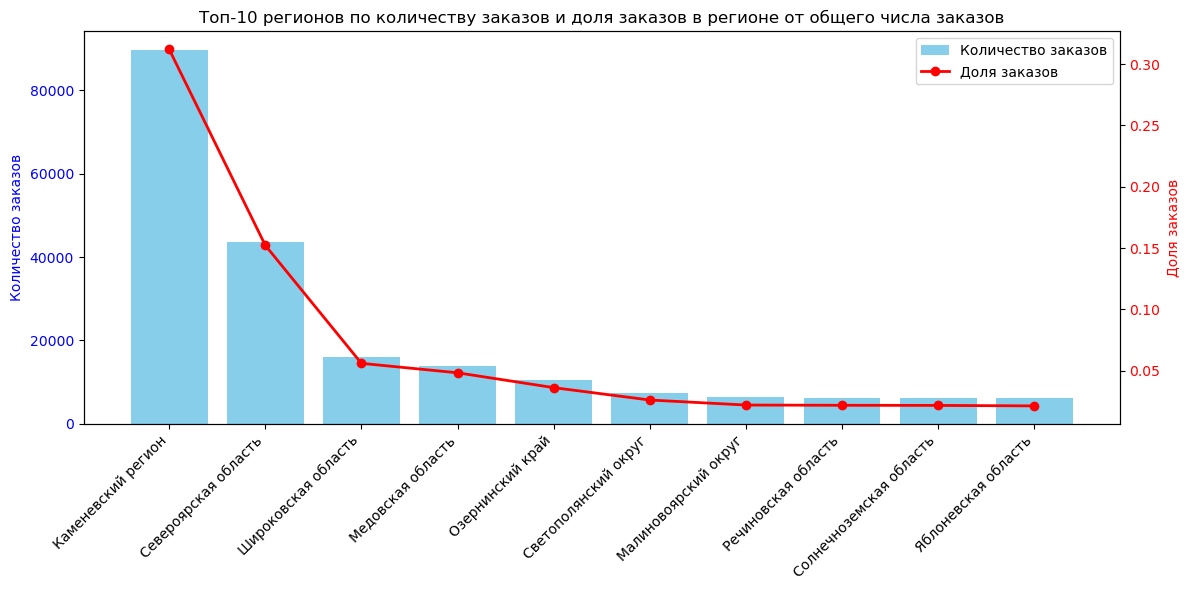

In [102]:
# Создаём контейнер для графика и задаём размер области вывода
fig, ax1 = plt.subplots(figsize=(12,6))

# Строим столбчатую диаграмму: количество заказов
bars = ax1.bar(top10_region_orders['region_name'], top10_region_orders['total_orders'], color='skyblue', label='Количество заказов')

# Настраиваем оформление графика
ax1.set_ylabel('Количество заказов', color='blue', fontsize=10)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticks(range(len(top10_region_orders['region_name'])))
ax1.set_xticklabels(top10_region_orders['region_name'], rotation=45, ha='right', fontsize=10)

# Строим линейный график: доля заказов
ax2 = ax1.twinx()
line = ax2.plot(top10_region_orders['region_name'], top10_region_orders['order_share'], color='red', marker='o', linewidth=2, label='Доля заказов')

# Настраиваем оформление графика
ax2.set_ylabel('Доля заказов', color='red', fontsize=10)
ax2.tick_params(axis='y', labelcolor='red')

# Настраиваем заголовок
plt.title('Топ-10 регионов по количеству заказов и доля заказов в регионе от общего числа заказов', fontsize=12)

# Настраиваем легенду
lines_labels = [bars, line[0]]
labels = [l.get_label() for l in lines_labels]
ax1.legend(lines_labels, labels, loc='upper right')

# Выводим график
plt.tight_layout()
plt.show()

**Результаты:**
 - Лидером является Каменевский регион с 89 665 заказами, что составляет 31,2% от общего числа заказов в топ-10 регионах.
 - На втором месте Североярская область с 43 725 заказами (15,2%).
 - Остальные регионы значительно отстают по количеству заказов, при этом суммарная доля заказов с 3-го по 10-й регион постепенно снижается до 2–5%.

 - Определим 10 регионов с наибольшим количеством уникальных мероприятий.

In [103]:
# Сортируем по убыванию количеству уникальных мероприятий
region_summary = region_summary.sort_values('unique_events', ascending=False)

# Берём топ-10 самых популярных регионов по количеству уникальных мероприятий
top10_region_events = region_summary.head(10).copy()

# Сбросим индекс для корректного отображения
top10_region_events = top10_region_events.reset_index(drop=True)

# Выводим таблицу
top10_region_events

,region_name,unique_events,total_orders,event_share,order_share
0,Каменевский регион,5935,89665,0.2662,0.3120
1,Североярская область,3798,43725,0.1704,0.1522
2,Широковская область,1225,16099,0.0550,0.0560
3,Светополянский округ,1068,7487,0.0479,0.0261
4,Речиновская область,701,6266,0.0314,0.0218
5,Травяная область,683,5036,0.0306,0.0175
6,Горицветская область,551,5153,0.0247,0.0179
7,Серебринская область,541,5586,0.0243,0.0194
8,Яблоневская область,534,6120,0.0240,0.0213
9,Тепляковская область,528,4384,0.0237,0.0153


Визуализируем топ-10 регионов по уникальным мероприятиям.

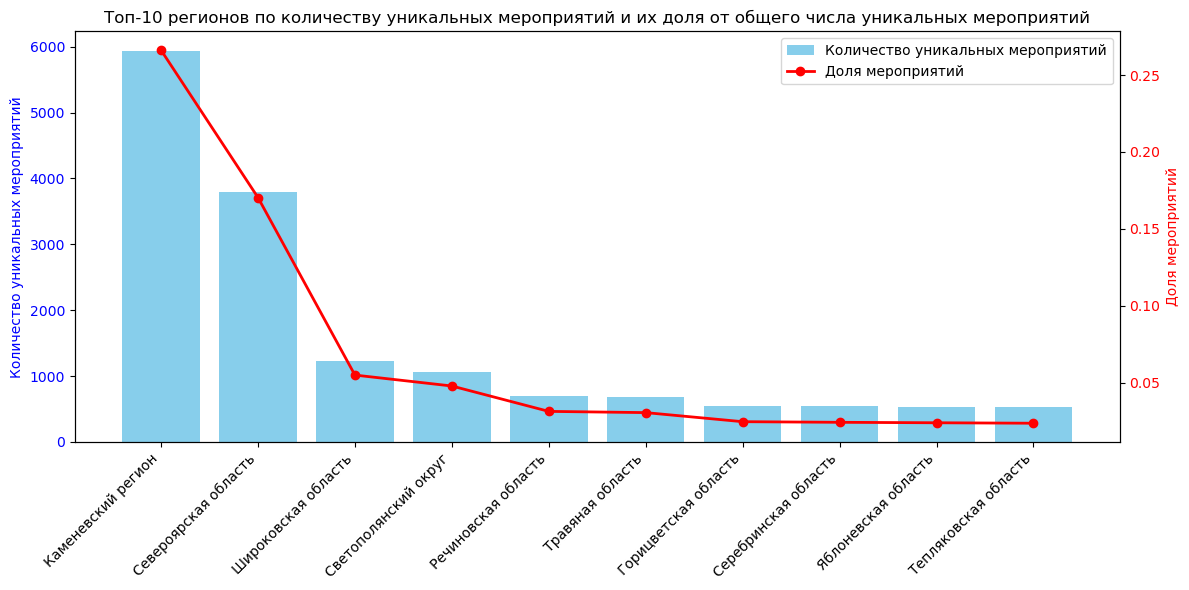

In [104]:
# Создаём контейнер для графика и задаём размер области вывода
fig, ax1 = plt.subplots(figsize=(12,6))

# Строим столбчатую диаграмму: количество заказов
bars = ax1.bar(top10_region_events['region_name'], top10_region_events['unique_events'], color='skyblue', label='Количество уникальных мероприятий')

# Настраиваем оформление графика
ax1.set_ylabel('Количество уникальных мероприятий', color='blue', fontsize=10)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticks(range(len(top10_region_events['region_name'])))
ax1.set_xticklabels(top10_region_events['region_name'], rotation=45, ha='right', fontsize=10)

# Строим линейный график: доля заказов
ax2 = ax1.twinx()
line = ax2.plot(top10_region_events['region_name'], top10_region_events['event_share'], color='red', marker='o', linewidth=2, label='Доля мероприятий')

# Настраиваем оформление графика
ax2.set_ylabel('Доля мероприятий', color='red', fontsize=10)
ax2.tick_params(axis='y', labelcolor='red')

# Настраиваем заголовок
plt.title('Топ-10 регионов по количеству уникальных мероприятий и их доля от общего числа уникальных мероприятий', fontsize=12)

# Настраиваем легенду
lines_labels = [bars, line[0]]
labels = [l.get_label() for l in lines_labels]
ax1.legend(lines_labels, labels, loc='upper right')

# Выводим график
plt.tight_layout()
plt.show()

**Результаты:**
 - Лидеры совпадают с рейтингом по заказам — Каменевский регион (5 935 мероприятий) и Североярская область (3 798 мероприятий).
 - В отличие от топ-10 по заказам, в список по уникальным мероприятиям вошли регионы с меньшим количеством заказов, но с большим разнообразием мероприятий, - Травяная и Горицветская области. Это показывает, что не всегда высокий объём заказов коррелирует с разнообразием мероприятий — некоторые регионы привлекают большое число заказов на относительно ограниченное количество событий.

 - Для каждого билетного партнёра рассчитаем общее число уникальных мероприятий, обработанных заказов и суммарную выручку с заказов билетов.

In [105]:
# Группируем по билетным партнёрам 
partner_summary = afisha_df.groupby('service_name', observed=True).agg(
        unique_events=('event_id', 'nunique'),   # Количество уникальных мероприятий
        total_orders=('order_id', 'count'),      # Общее число заказов
        total_revenue=('revenue_rub', 'sum')    # Суммарная выручка в рублях
).reset_index()

# Сортируем по числу заказов 
partner_summary = partner_summary.sort_values('total_orders', ascending=False)

# Берём топ-10 наиболее активных партнёров
top10_partners = partner_summary.head(10)

# Сбросим индекс для корректного отображения
top10_partners = top10_partners.reset_index(drop=True)

# Выводим таблицу
top10_partners

,service_name,unique_events,total_orders,total_revenue
0,Билеты без проблем,4210,62633,26496052.00
1,Лови билет!,4859,40766,16675517.00
2,Билеты в руки,3517,40188,13194799.00
3,Мой билет,1299,34434,39390728.00
4,Облачко,2335,26402,18588614.00
5,Лучшие билеты,1755,17715,2724084.25
6,Весь в билетах,855,16425,16533231.00
7,Прачечная,1026,10222,4746810.50
8,Край билетов,252,6109,6405689.00
9,Тебе билет!,1061,5189,2962308.75


Построим графики по полученной таблице, чтобы наглядно сравнить топ-партнёров по количеству заказов, доле выручки и количеству уникальных мероприятий.

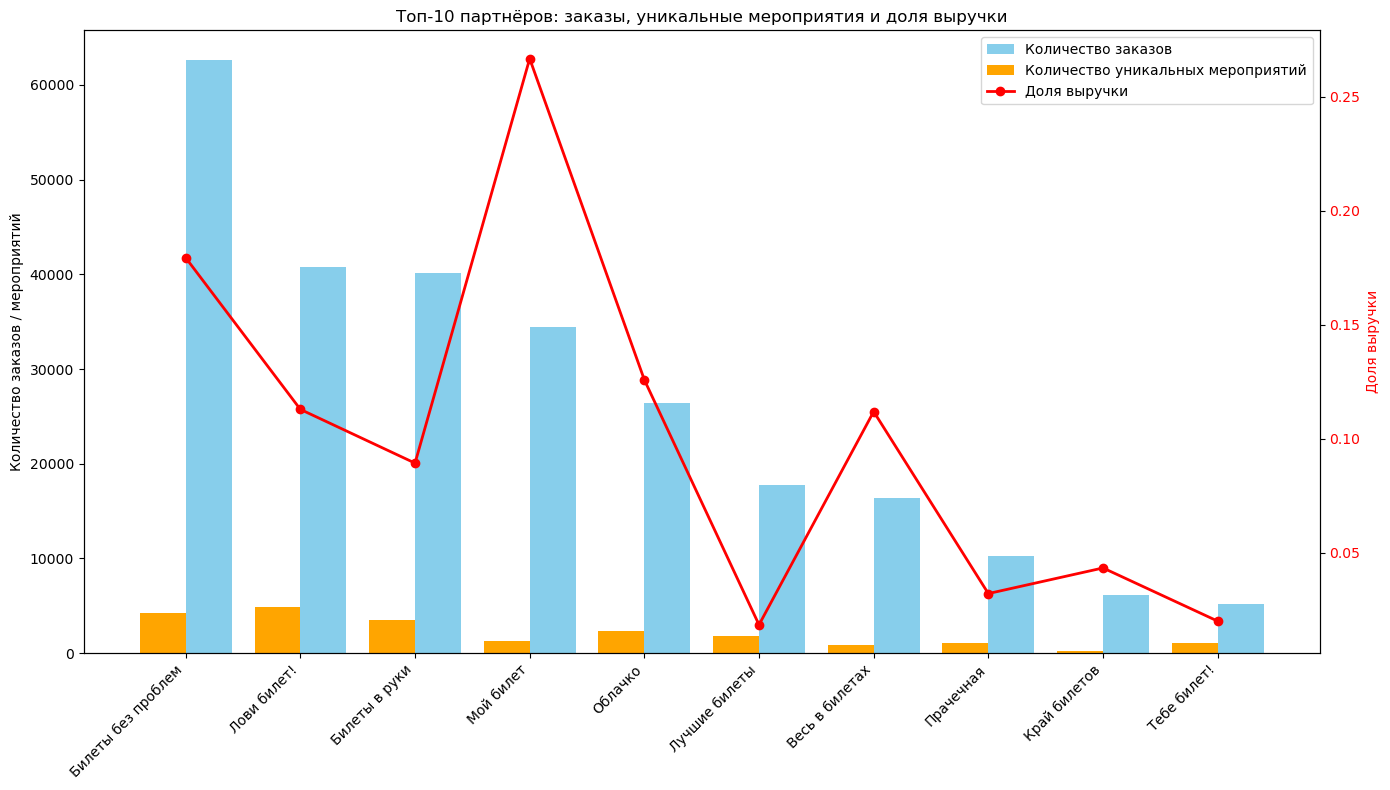

In [106]:
fig, ax1 = plt.subplots(figsize=(14,8))

# Столбцы: количество заказов
bars_orders = ax1.bar(top10_partners['service_name'], top10_partners['total_orders'], color='skyblue', label='Количество заказов', width=0.4, align='edge')

# Столбцы: количество уникальных мероприятий
bars_events = ax1.bar(top10_partners['service_name'], top10_partners['unique_events'], color='orange', label='Количество уникальных мероприятий', width=-0.4, align='edge')

ax1.set_ylabel('Количество заказов / мероприятий', fontsize=10)
ax1.set_xticks(range(len(top10_partners['service_name'])))
ax1.set_xticklabels(top10_partners['service_name'], rotation=45, ha='right', fontsize=10)

# Линия: доля выручки
ax2 = ax1.twinx()
top10_partners['revenue_share'] = top10_partners['total_revenue'] / top10_partners['total_revenue'].sum()
line = ax2.plot(top10_partners['service_name'], top10_partners['revenue_share'], color='red', marker='o', linewidth=2, label='Доля выручки')
ax2.set_ylabel('Доля выручки', color='red', fontsize=10)
ax2.tick_params(axis='y', labelcolor='red')

# Легенда
lines_labels = [bars_orders, bars_events, line[0]]
labels = [l.get_label() for l in lines_labels]
ax1.legend(lines_labels, labels, loc='upper right')

plt.title('Топ-10 партнёров: заказы, уникальные мероприятия и доля выручки', fontsize=12)
plt.tight_layout()
plt.show()


**Результаты:**

1. Топ-10 партнёров по количеству заказов
 - Лидеры: «Билеты без проблем» (62633), «Лови билет!» (40766), «Билеты в руки» (40188) - эти партнёры формируют основной объём заказов.
 - «Мой билет» — на 4-м месте по заказам, но уже в числе лидеров по выручке → партнёр делает ставку на более дорогие события.

2. Топ-10 партнёров по суммарной выручке
 - Лидеры: «Мой билет» — 39,39 млн.руб., «Билеты без проблем» — 26,50 млн.руб., «Облачко» — 18,59 млн.руб.
 - Высокая выручка не всегда связана с большим числом заказов.

3. Топ-10 по уникальным мероприятиям
 - Лидеры по ассортименту: «Лови билет!» (4859 событий), «Билеты без проблем» (4210), «Билеты в руки» (3517).
 - Широкий каталог помогает привлекать разную аудиторию.
 - «Мой билет» имеет относительно мало мероприятий (1299), но высокую выручку  - сделана ставка на премиальные события.

4. Можно выделить три стратегии партнёров:
 - Высокий охват и много заказов — «Билеты без проблем», «Лови билет!».
 - Высокодоходная модель с меньшим числом мероприятий — «Мой билет».
 - Средние показатели по большинству метрик — «Облачко», «Билеты в руки».

**Промежуточный вывод**

1. Распределение заказов и мероприятий по регионам:
 - Явные лидеры по количеству заказов и уникальных мероприятий — Каменевский регион и Североярская область.
 - Они формируют значительную долю как по объёму событий, так и по заказам: топ-2 региона покрывают почти половину всех заказов.
 - Остальные регионы распределяются более равномерно, но их доля заметно меньше — нет критического перепада между средними регионами, кроме нескольких менее активных областей.

2. Распределение по партнёрам:
 - Явными лидерами по числу заказов являются «Билеты без проблем», «Лови билет!» и «Билеты в руки».
 - По суммарной выручке лидирует «Мой билет», демонстрируя стратегию меньшего количества мероприятий, но с высокой ценой билета.
 - По уникальным мероприятиям лидирует «Лови билет!», что указывает на широкий ассортимент.
 - Среди партнёров видны различные стратегии: кто-то ориентирован на объём заказов, кто-то на высокодоходные события, а кто-то сочетает умеренные показатели по всем метрикам.

3. Общее распределение:
 - Основная масса заказов и выручки сосредоточена у нескольких ведущих регионов и партнёров.
 - При этом менее крупные регионы и партнёры занимают значительную часть рынка по количеству уникальных мероприятий, что показывает разнообразие предложений и возможности для роста.

**Вывод:**
 - Явные лидеры существуют: Каменевский регион и Североярская область среди регионов, «Билеты без проблем», «Лови билет!» и «Мой билет» среди партнёров.
 - Одновременно, рынок остаётся достаточно разнообразным, особенно по уникальным мероприятиям, что создаёт возможности для оптимизации продаж и расширения присутствия на менее активных регионах и у партнёров.

<a class = "anchor" id = "4-stat" ><a/>
## Статистический анализ данных

Проверим несколько гипотез относительно активности пользователей мобильных и стационарных устройств **по данным за осенний период**:

1. **Среднее количество заказов** на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.


Определим целевую метрику и сформулируем нулевую и альтернативную гипотезы.

 - Целевая метрика: среднее количество заказов на одного пользователя. Эта метрика отражает активность пользователя в приложении — сколько заказов он совершает за выбранный период.

 - Нулевая гипотеза $H_0: \mu_{\text{mobile}} \leq \mu_{\text{desktop}}$ <br>

Среднее количество заказов на одного пользователя мобильного приложения не больше, чем у пользователей стационарных устройств.

 - Альтернативная гипотеза $H_1: \mu_{\text{mobile}} > \mu_{\text{desktop}}$ <br>
   
Среднее количество заказов на одного пользователя мобильного приложения больше, чем у пользователей стационарных устройств, и это различие статистически значимо.

 - Тип гипотезы: Односторонняя
 - Уровень значимости равен 0.05.

2. **Среднее время между заказами** пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.

Определим целевую метрику и сформулируем нулевую и альтернативную гипотезы.

 - Целевая метрика: среднее время между заказами пользователя. Эта метрика отражает, как часто пользователь делает заказы: большее значение — реже, меньшее — чаще.

 - Нулевая гипотеза $H_0: \mu_{\text{mobile}} \leq \mu_{\text{desktop}}$ <br>
 
Среднее время между заказами пользователей мобильного приложения не больше, чем у пользователей стационарных устройств.

 - Альтернативная гипотеза $H_1: \mu_{\text{mobile}} > \mu_{\text{desktop}}$ <br>
   
Среднее время между заказами пользователей мобильного приложения больше, чем у пользователей стационарных устройств, и это различие статистически значимо.

 - Тип гипотезы: Односторонняя
 - Уровень значимости равен 0.05.

In [107]:
alpha = 0.05

 - Рассчитаем количество пользователей, которые встречаются одновременно в группах desktop и mobile (или найдем, что таких нет).

In [108]:
# Получаем множества уникальных пользователей по типу устройства
desktop_users = set(afisha_df_autumn.loc[afisha_df_autumn['device_type_canonical']=='desktop', 'user_id'])
mobile_users = set(afisha_df_autumn.loc[afisha_df_autumn['device_type_canonical']=='mobile', 'user_id'])

# Находим пересечение
common_users = desktop_users & mobile_users

# Выводим результат
print(f"Количество пользователей, которые встречаются в обеих группах: {len(common_users)}")

Количество пользователей, которые встречаются в обеих группах: 3249


Визуализируем пересечение пользователей с помощью диаграммы Венна.

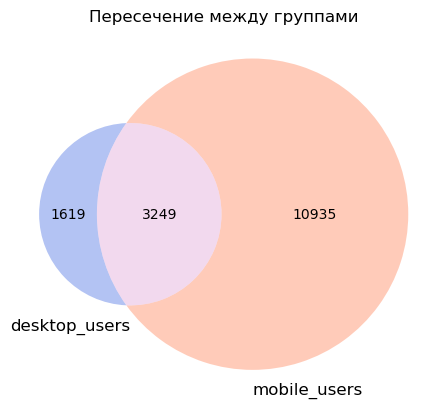

In [109]:
first_id = desktop_users
second_id = mobile_users
# Строим диаграмму Венна
venn2([first_id, second_id], set_labels=('desktop_users', 'mobile_users'), set_colors=('royalblue', 'coral'))

# Отображаем график
plt.title("Пересечение между группами")
plt.show()

Удалим всех пользователей, которые встречаются в обеих группах, из обеих выборок. Это гарантирует независимость выборок и корректность результатов статистических тестов.

In [110]:
# Удалим пересекающихся пользователей из выборок
afisha_df_autumn = afisha_df_autumn[~afisha_df_autumn['user_id'].isin(common_users)]

 - Сравним размеры выборок по типам устройств.
Для этого рассчитаем количество уникальных пользователей в каждой из групп и на основе этих данных построим столбчатую диаграмму.

In [111]:
# Расчёт количества уникальных пользователей по типу устройства
unique_users_per_device = afisha_df_autumn.groupby('device_type_canonical', observed=True)['user_id'].nunique().reset_index().rename(columns={'user_id': 'unique_users'})

In [112]:
# Вывод на экран
print("Количество уникальных пользователей по типу устройства (осень):")
display(unique_users_per_device)

Количество уникальных пользователей по типу устройства (осень):


,device_type_canonical,unique_users
0,desktop,1619
1,mobile,10935


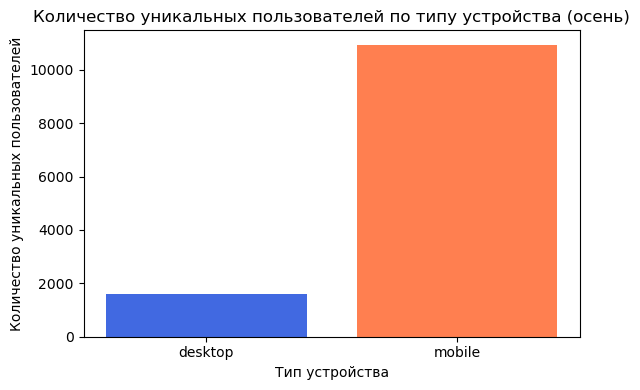

In [113]:
# Создаём контейнер для графика и задаём размер области вывода
plt.figure(figsize=(6, 4))

# Строим столбчатую диаграмму
plt.bar(unique_users_per_device['device_type_canonical'], unique_users_per_device['unique_users'], color=['royalblue', 'coral'])

# Настраиваем оформление графика
plt.title('Количество уникальных пользователей по типу устройства (осень)')
plt.xlabel('Тип устройства')
plt.ylabel('Количество уникальных пользователей')
plt.grid(False)

# Выводим график
plt.tight_layout()
plt.show()

В исследовании рассматриваются две группы пользователей по типу устройства: desktop (1619 уникальных пользователей) и mobile (10935 уникальных пользователей). Размеры выборок различаются — мобильная группа почти в 6,8 раза больше. Эта разница не препятствует проведению статистического анализа, однако для корректного сравнения средних значений следует учитывать возможность неравенства дисперсий.

- Проверим, что пользователи равномерно распределены по типам мероприятий.

Выполним группировку данных по группе и типу мероприятия с расчётом числа уникальных пользователей в каждой категории.

In [114]:
# Разделяем данные по типу устройства
desktop_df = afisha_df_autumn[afisha_df_autumn['device_type_canonical'] == 'desktop']
mobile_df = afisha_df_autumn[afisha_df_autumn['device_type_canonical'] == 'mobile']

In [115]:
# Считаем долю пользователей по типу мероприятия для каждой группы
desktop_dist = desktop_df.groupby('event_type_main', observed=False)['user_id'].nunique().reset_index().rename(columns={'user_id': 'users_count'})
desktop_dist['percent'] = (desktop_dist['users_count'] / desktop_dist['users_count'].sum() * 100).round(2)

mobile_dist = mobile_df.groupby('event_type_main', observed=False)['user_id'].nunique().reset_index().rename(columns={'user_id': 'users_count'})
mobile_dist['percent'] = (mobile_dist['users_count'] / mobile_dist['users_count'].sum() * 100).round(2)

In [116]:
# Вывод на экран
print("Распределение пользователей по типам мероприятий — Desktop:")
display(desktop_dist)

print("\nРаспределение пользователей по типам мероприятий — Mobile:")
display(mobile_dist)

Распределение пользователей по типам мероприятий — Desktop:


,event_type_main,users_count,percent
0,выставки,14,0.79
1,другое,342,19.39
2,концерты,696,39.46
3,спорт,104,5.90
4,стендап,86,4.88
5,театр,496,28.12
6,ёлки,26,1.47



Распределение пользователей по типам мероприятий — Mobile:


,event_type_main,users_count,percent
0,выставки,333,2.28
1,другое,3431,23.45
2,концерты,5587,38.19
3,спорт,912,6.23
4,стендап,843,5.76
5,театр,3343,22.85
6,ёлки,181,1.24


Построим две диаграммы:
 - доля каждого типа мероприятия для пользователей из группы desktop,
 - доля каждого типа мероприятия для пользователей из группы mobile.

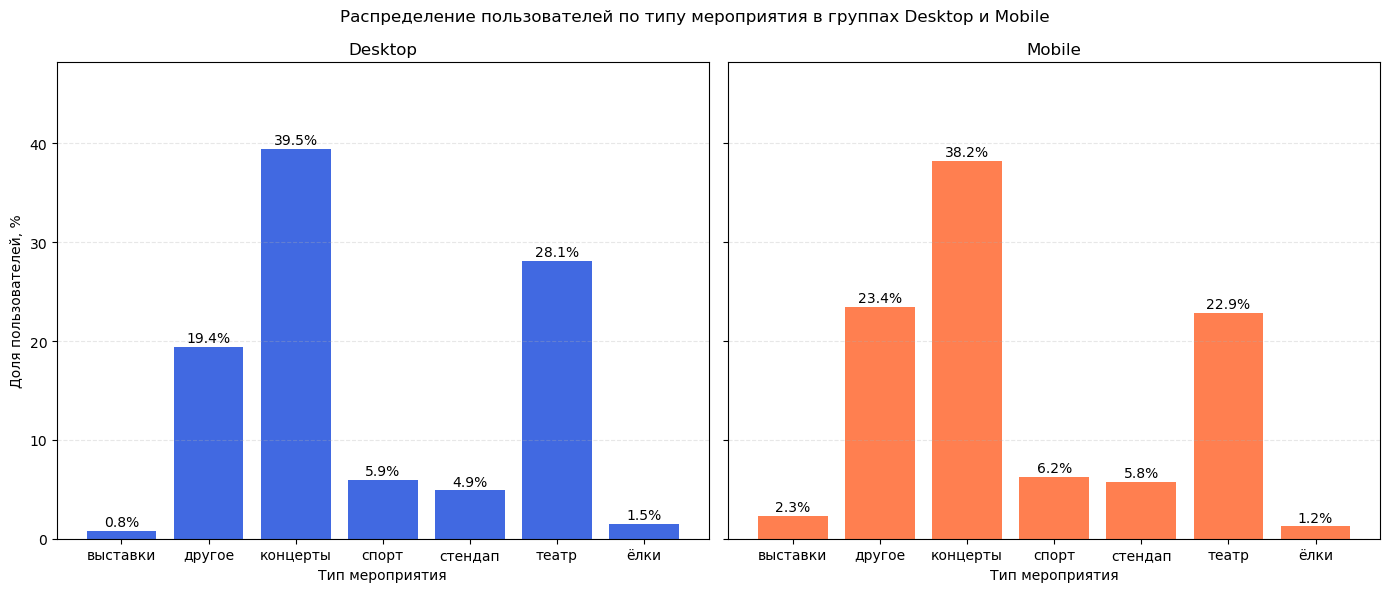

In [117]:
# Создаём контейнер для графиков и задаём размер области вывода
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Строим диаграмму (группа Desktop)
axes[0].bar(desktop_dist['event_type_main'], desktop_dist['percent'], color='royalblue')

# Настраиваем оформление графика (группа Desktop)
axes[0].set_title('Desktop')
axes[0].set_xlabel('Тип мероприятия')
axes[0].set_ylabel('Доля пользователей, %')
axes[0].set_ylim(0, desktop_dist['percent'].max() + 10)
axes[0].grid(axis='y', linestyle='--', alpha=0.3)
for i, v in enumerate(desktop_dist['percent']):
    axes[0].text(i, v + 0.5, f'{v:.1f}%', ha='center', fontsize=10)

# Строим диаграмму (группа Mobile)
axes[1].bar(mobile_dist['event_type_main'], mobile_dist['percent'], color='coral')

# Настраиваем оформление графика (группа Mobile)
axes[1].set_title('Mobile')
axes[1].set_xlabel('Тип мероприятия')
axes[1].set_ylim(0, mobile_dist['percent'].max() + 10)
axes[1].grid(axis='y', linestyle='--', alpha=0.3)
for i, v in enumerate(mobile_dist['percent']):
    axes[1].text(i, v + 0.5, f'{v:.1f}%', ha='center', fontsize=10)

# Настраиваем оформление графика    
plt.suptitle('Распределение пользователей по типу мероприятия в группах Desktop и Mobile')

# Выводим график
plt.tight_layout()
plt.show()

**Результат:** в обеих группах лидируют концерты, театр и категория «другое», структура распределений в целом похожа.

 - Проверим, что пользователи равномерно распределены по типам возрастного рейтинга мероприятий.
Выполним группировку данных по группе и типу возрастного рейтинга с расчётом числа уникальных пользователей в каждой категории.

In [118]:
# Считаем долю пользователей по возрастному рейтингу для каждой группы
desktop_age = desktop_df.groupby('age_limit', observed=False)['user_id'].nunique().reset_index().rename(columns={'user_id': 'users_count'})
desktop_age['percent'] = (desktop_age['users_count'] / desktop_age['users_count'].sum() * 100).round(2)

mobile_age = mobile_df.groupby('age_limit', observed=False)['user_id'].nunique().reset_index().rename(columns={'user_id': 'users_count'})
mobile_age['percent'] = (mobile_age['users_count'] / mobile_age['users_count'].sum() * 100).round(2)

In [119]:
# Вывод на экран
print("Распределение пользователей по возрастному рейтингу — Desktop:")
display(desktop_age)

print("\nРаспределение пользователей по возрастному рейтингу — Mobile:")
display(mobile_age)

Распределение пользователей по возрастному рейтингу — Desktop:


,age_limit,users_count,percent
0,0,294,16.32
1,6,383,21.25
2,12,409,22.70
3,16,481,26.69
4,18,235,13.04



Распределение пользователей по возрастному рейтингу — Mobile:


,age_limit,users_count,percent
0,0,3037,19.87
1,6,2959,19.36
2,12,3347,21.89
3,16,3975,26.00
4,18,1970,12.89


Построим две диаграммы:
 - доля каждого возрастного рейтинга для пользователей из группы desktop,
 - доля каждого возрастного рейтинга для пользователей из группы mobile.

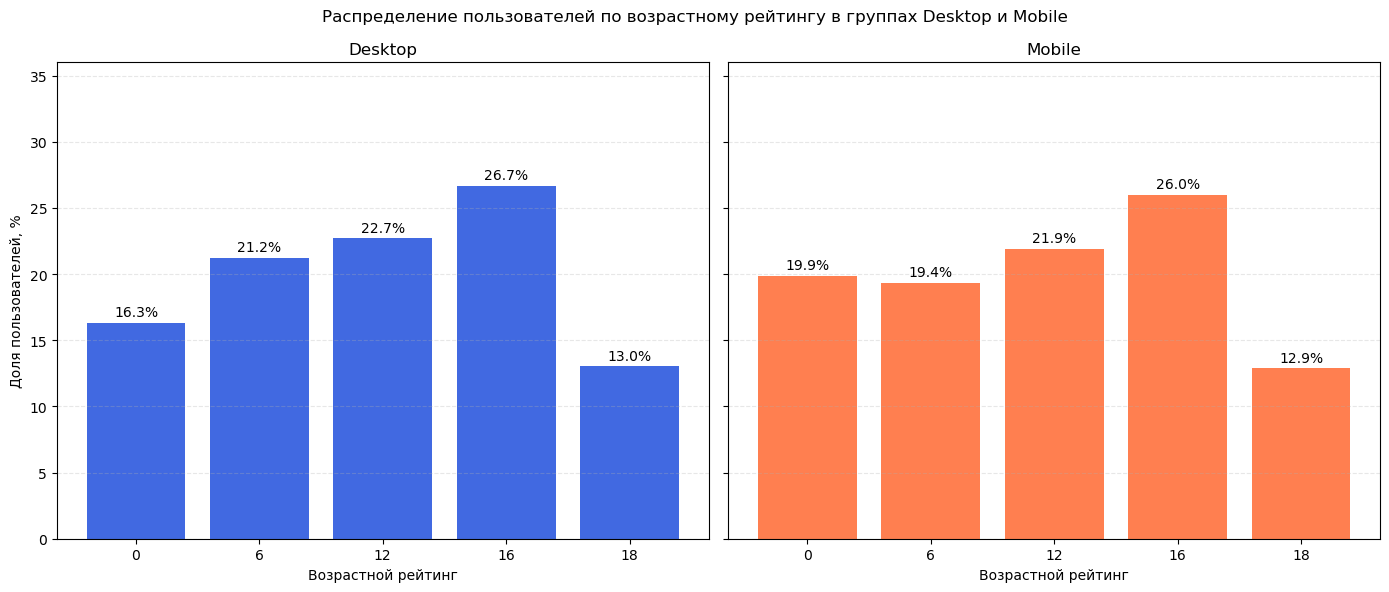

In [120]:
# Создаём контейнер для графиков и задаём размер области вывода
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Строим диаграмму (группа Desktop)
axes[0].bar(desktop_age['age_limit'].astype(str), desktop_age['percent'], color='royalblue')

# Настраиваем оформление графика (группа Desktop)
axes[0].set_title('Desktop')
axes[0].set_xlabel('Возрастной рейтинг')
axes[0].set_ylabel('Доля пользователей, %')
axes[0].set_ylim(0, desktop_age['percent'].max() + 10)
axes[0].grid(axis='y', linestyle='--', alpha=0.3)
for i, v in enumerate(desktop_age['percent']):
    axes[0].text(i, v + 0.5, f'{v:.1f}%', ha='center', fontsize=10)

# Строим диаграмму (группа Mobile)
axes[1].bar(mobile_age['age_limit'].astype(str), mobile_age['percent'], color='coral')

# Настраиваем оформление графика (группа Mobile)
axes[1].set_title('Mobile')
axes[1].set_xlabel('Возрастной рейтинг')
axes[1].set_ylim(0, mobile_age['percent'].max() + 10)
axes[1].grid(axis='y', linestyle='--', alpha=0.3)
for i, v in enumerate(mobile_age['percent']):
    axes[1].text(i, v + 0.5, f'{v:.1f}%', ha='center', fontsize=10)

# Настраиваем оформление графика
plt.suptitle('Распределение пользователей по возрастному рейтингу в группах Desktop и Mobile')

# Выводим график
plt.tight_layout()
plt.show()

**Результаты:**
 - Распределение пользователей по возрастным рейтингам в группах Desktop и Mobile является практически одинаковым — доли по каждому возрастному диапазону отличаются не более чем на 1–3%.
 - Основная часть пользователей в обеих группах относится к возрастным категориям 12+ и 16+, которые суммарно формируют более половины аудитории.

- Для каждой группы найдем среднее количество заказов на пользователя и среднее время между заказами.

In [121]:
# Группируем по пользователю и считаем среднее количество заказов на пользователя
desktop_stats = desktop_df.groupby('user_id').agg(
    orders_per_user=('order_id', 'count'),        # количество заказов на пользователя
    mean_days_between=('days_since_prev', 'mean') # среднее время между заказами
).reset_index()

mobile_stats = mobile_df.groupby('user_id').agg(
    orders_per_user=('order_id', 'count'),
    mean_days_between=('days_since_prev', 'mean')
).reset_index()

Оценим ститистические показатели столбца `orders_per_user` по каждой группе (Desktop/Mobile), используя метод describe():

In [122]:
# Изучаем статистические показатели 
desktop_stats['orders_per_user'].describe()

count    1619.00000
mean        1.97097
std         3.05771
min         1.00000
25%         1.00000
50%         1.00000
75%         2.00000
max        56.00000
Name: orders_per_user, dtype: float64

In [123]:
# Изучаем статистические показатели 
mobile_stats['orders_per_user'].describe()

count    10935.000000
mean         2.856882
std          4.096770
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max        123.000000
Name: orders_per_user, dtype: float64

Построим диаграмму размаха распределения среднего числа заказов на пользователя по двум группам без отображения выбросов.

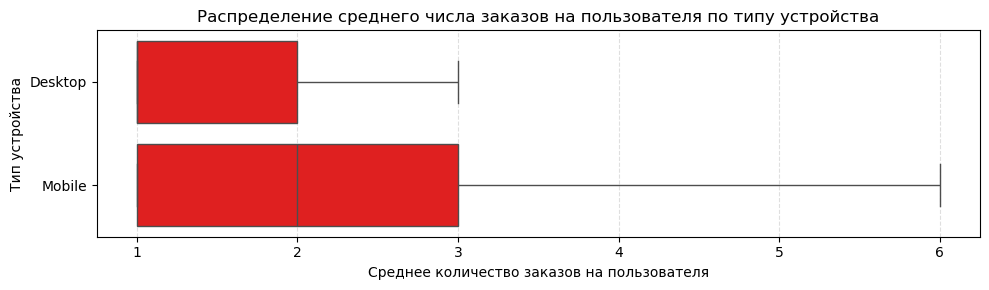

In [124]:
# Добавляем столбец device_type в каждую группу
desktop_stats = desktop_stats.copy()
desktop_stats['device_type'] = 'Desktop'

mobile_stats = mobile_stats.copy()
mobile_stats['device_type'] = 'Mobile'

# Объединяем данные для удобной визуализации
combined_stats = pd.concat([desktop_stats, mobile_stats], ignore_index=True)

# Создаём контейнер для графика и задаём размер области вывода
plt.figure(figsize=(10, 3))

# Строим диаграмму размаха среднего количества заказов на пользователя по типу устройства
sns.boxplot(data=combined_stats,          
    x='orders_per_user',
    y='device_type',
    showfliers=False,             
    orient='h',
    color='red')

# Настраиваем оформление графика
plt.title('Распределение среднего числа заказов на пользователя по типу устройства')
plt.xlabel('Среднее количество заказов на пользователя')
plt.ylabel('Тип устройства')
plt.grid(axis='x', linestyle='--', alpha=0.4)

# Выводим график
plt.tight_layout()
plt.show()

**Результаты:**
 - Мобильные пользователи делают больше заказов: среднее — 2.86 против 1.97 у desktop.
 - Основная масса пользователей совершает мало заказов, но мобильная аудитория чаще переходит к 2–3 покупкам.
 - Пользователи мобильных устройств значительно активнее: они совершают больше заказов, более неоднородны по активности и обеспечивают большее количество высокоактивных клиентов. Это предварительно подтверждает предположение о большей вовлечённости мобильной аудитории.

Оценим ститистические показатели столбца `mean_days_between` по каждой группе (Desktop/Mobile), используя метод describe():

In [125]:
# Изучаем статистические показатели 
desktop_stats['mean_days_between'].describe()

count    894.000000
mean      31.357178
std       36.564091
min        0.000000
25%        0.000000
50%       16.000000
75%       53.000000
max      146.000000
Name: mean_days_between, dtype: float64

In [126]:
# Изучаем статистические показатели 
mobile_stats['mean_days_between'].describe()

count    7052.000000
mean       25.254791
std        30.210052
min         0.000000
25%         2.870536
50%        14.000000
75%        36.000000
max       148.000000
Name: mean_days_between, dtype: float64

Построим диаграмму размаха распределения среднего времени между заказами по двум группам без отображения выбросов.

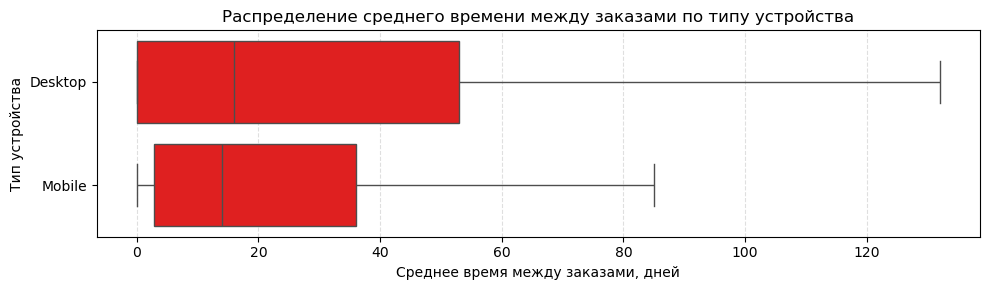

In [127]:
# Создаём контейнер для графика и задаём размер области вывода
plt.figure(figsize=(10, 3))

# Строим boxplot среднего времени между заказами по типу устройства
sns.boxplot(
    data=combined_stats,          
    x='mean_days_between',
    y='device_type',
    showfliers=False,            
    orient='h',
    color='red')

# Настраиваем оформление графика
plt.title('Распределение среднего времени между заказами по типу устройства')
plt.xlabel('Среднее время между заказами, дней')
plt.ylabel('Тип устройства')
plt.grid(axis='x', linestyle='--', alpha=0.4)

# Выводим график
plt.tight_layout()
plt.show()

**Результаты:**
1. Мобильные пользователи совершают заказы заметно чаще:
- Медиана у mobile — 14 дней, у desktop — 16 дней.
- Среднее время между заказами: mobile — 25,3 дней, desktop — 31,4 дней.
- Мобильная аудитория возвращается быстрее и делает заказы регулярно. Это предварительно не подтверждает предположение о большей вовлечённости пользователей стационарных устройств по сравнению с мобильной аудиторией.

2. Пользователи desktop демонстрируют более нерегулярную активность:
- Стандартное отклонение desktop — 36,6, mobile — 30,2.
- Наличие пользователей с очень длинными интервалами между заказами.

Таким образом, выборки сбалансированы по ключевым характеристикам, распределения пользователей по типу мероприятия и возрасту схожи, независимость соблюдена. Предварительные данные указывают на более высокую вовлечённость мобильной аудитории, что обосновывает дальнейшую проверку гипотез.

Для проверки гипотез целесообразно использовать **непараметрический тест Манна–Уитни** из-за наличия выбросов и скошенных распределений. Тест корректно сравнивает медианы двух независимых групп (desktop и mobile), не требуя нормальности и устойчив к экстремальным значениям.

 - Используем тест Манна - Уитни для проверки первой гипотезы: среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.

In [128]:
# Выбираем метрику для сравнения
desktop_orders = desktop_stats['orders_per_user']
mobile_orders = mobile_stats['orders_per_user']

# Применяем тест Манна–Уитни (альтернатива: мобильные пользователи делают больше заказов)
u_stat_1, p_value_mw_test_1 = mannwhitneyu(mobile_orders, desktop_orders, alternative='greater')

# Вывод результатов
print(f"Статистика U: {u_stat_1:.2f}, p-value: {p_value_mw_test_1}")

Статистика U: 10493662.00, p-value: 4.7602249799150366e-39


In [129]:
# Интерпретация результата
if p_value_mw_test_1 > alpha:
    print("Недостаточно доказательств для отклонения нулевой гипотезы.")
else:
    print("Отвергаем нулевую гипотезу: среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.")

Отвергаем нулевую гипотезу: среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.


Результаты теста Манна–Уитни показали, что пользователи мобильного приложения совершают статистически значимо больше заказов по сравнению с пользователями стационарных устройств.

 - Используем тест Манна - Уитни для проверки второй гипотезы: среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.

In [130]:
# Выбираем метрику для сравнения
desktop_days = desktop_stats['mean_days_between'].dropna()
mobile_days = mobile_stats['mean_days_between'].dropna()

# Применяем тест Манна–Уитни (альтернатива: мобильные пользователи делают заказы реже)
u_stat_2, p_value_mw_test_2 = mannwhitneyu(mobile_days, desktop_days, alternative='greater')

# Вывод результатов
print(f"Статистика U: {u_stat_2:.2f}, p-value: {p_value_mw_test_2:.5f}")

Статистика U: 3099859.50, p-value: 0.79215


In [131]:
# Интерпретация результата
if p_value_mw_test_2 > alpha:
    print("Недостаточно доказательств для отклонения нулевой гипотезы.")
else:
    print("Отвергаем нулевую гипотезу: среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.")

Недостаточно доказательств для отклонения нулевой гипотезы.


Результаты теста Манна–Уитни показали, что статистически значимых доказательств в пользу того, что мобильные пользователи имеют большее среднее время между заказами, не найдено.

<a class = "anchor" id = "5-summary" ><a/>
## Общий вывод и рекомендации

В ходе исследования были изучены данные **сервиса Яндекс Афиша за 2024 год**, включающие информацию о заказах, пользователях, мероприятиях, билетных партнёрах и курсах валют. После предобработки были устранены дубликаты, выявлены и обработаны выбросы, а выручка приведена к единой валюте. Также были сформированы новые признаки: стоимость одного билета, месяц оформления заказа и сезон.

**Основные результаты анализа**

**1. Популярность мероприятий и сезонность**
 - Осенний период характеризуется ярко выраженным ростом пользовательской активности по сравнению с концом лета: увеличивается число заказов, расширяется аудитория, достигая пиковых значений в октябре. Это совпадает с окончанием отпусков, возвращением пользователей в город, ростом числа мероприятий и переходом интереса от летних уличных форматов к событиям в помещениях.

 - Структура интереса по категориям заметно меняется. Осенью снижается доля концертов и разноплановых мероприятий, тогда как театр уверенно растёт, спорт увеличивается в несколько раз за счёт начала спортивных сезонов, а спрос на новогодние мероприятия («ёлки») начинает формироваться заранее. Спрос на выставки остаётся относительно стабильным, а стендап демонстрирует лишь небольшое снижение доли, сохраняя популярность. В целом структура смещается в сторону театра, спорта и праздничных событий.

 - Поведение пользователей различается и по устройствам: мобильные устройства остаются доминирующим каналом заказов как летом, так и осенью (около 80%). Осенью наблюдается лишь незначительный сдвиг в сторону desktop, что указывает на стабильность каналов и отсутствие существенных изменений в паттернах использования.

 - Осенью также изменяется возрастная структура аудитории. Увеличивается доля заказов для младших и средних возрастов (категории 0+ и 12+), тогда как доля мероприятий 16+ и 18+ снижается, что может указывать на уменьшение активности зрелой аудитории. Категория 6+ остаётся на уровне предыдущего сезона.

 - Средняя стоимость билетов демонстрирует неоднородную динамику: в ряде категорий (выставки, стендап) наблюдается рост среднего чека, тогда как в концертах, театре и новогодних мероприятиях чек снижается — вероятно, из-за повышенного предложения, сезонных скидок или выбора более доступных мест. Таким образом, выручка по категориям существенно различается и подвержена сезонным колебаниям.

**2. Пользовательская активность осенью**
 - Осенью фиксируется выраженный сезонный рост активности: общее число заказов и количество уникальных пользователей стабильно увеличиваются от начала сентября к концу октября. При этом среднее число заказов на пользователя остаётся на постоянном уровне (около 2,7–3,1), что указывает на стабильное поведение аудитории при общем росте спроса.

 - Активность демонстрирует чёткую недельную цикличность.
Будние дни являются явными лидерами по числу заказов и DAU — особенно вторник и пятница. В выходные активность ниже: количество заказов падает примерно на 18%, а число активных пользователей — на 5%. Однако средний чек в выходные заметно выше, что отражает выбор более дорогих мероприятий или посещение премиальных мест.

 - В будние дни пользователи совершают в среднем больше заказов на человека, тогда как в выходные делают меньше покупок, но на более высокую сумму. Сезонная динамика в целом показывает рост интереса к мероприятиям в осенний период при сохранении устоявшихся недельных поведенческих паттернов.

**3. Регионы и партнёры**

 - Основные объёмы заказов и разнообразие мероприятий сосредоточены в крупных регионах — Каменевском регионе и Североярской области. Эти два лидера обеспечивают почти половину всех заказов и значительную часть всех уникальных событий. Остальные регионы демонстрируют более равномерное, но заметно меньшее участие.

 - Среди билетных партнёров выделяется несколько ключевых игроков:
     - по числу заказов — «Билеты без проблем», «Лови билет!» и «Билеты в руки»;
     - по суммарной выручке — «Мой билет», предлагающий менее массовые, но более дорогие мероприятия;
     - по ассортименту уникальных событий — «Лови билет!».

 - Таким образом, рынок имеет чётко выраженных лидеров, которые формируют основную долю заказов и дохода. Остальные партнёры обеспечивают меньшие объёмы, но играют важную роль в поддержании разнообразия предложений и могут рассматриваться как точки роста.


**Проверка гипотез**

**1. Среднее количество заказов на пользователя выше у мобильной аудитории.**
Тест Манна–Уитни показал статистически значимое превосходство мобильных устройств. Пользователи мобильного приложения оформляют заметно больше заказов.

**2. Среднее время между заказами больше у мобильных пользователей.**
Гипотеза не подтвердилась. По тесту различий нет, а по описательным метрикам мобильные пользователи, наоборот, возвращаются быстрее. Это указывает на более стабильную и регулярную активность мобильной аудитории.


**Рекомендации**

1. Фокус на мобильном приложении: мобильные пользователи демонстрируют более высокую активность -  они совершают больше заказов и возвращаются быстрее, а доля мобильных устройств стабильно держится на уровне 80% вне зависимости от сезона. Рекомендуется развитие мобильных функций, персонализации и маркетинговых активностей.

2. Работа с осенним пиком спроса: осень — ключевой сезон, стоит заранее планировать рекламные кампании к началу осени, расширять ассортимент мероприятий и усиливать коммуникации в этот период.

3. Сезонная персонализация по категориям: осенью аудитория смещает внимание в сторону театра, спорта и мероприятий для детей, поэтому именно эти направления должны стать приоритетом в рекомендациях и промо. Выставки и стендап остаются стабильными драйверами выручки — их можно использовать для формирования премиальных предложений. Доля концертов осенью снижается, поэтому их стоит поддерживать, но с меньшим маркетинговым приоритетом.

4. Оптимизация сотрудничества с партнёрами: партнёры, которые обеспечивают значительную долю выручки, представляют собой стратегическую ценность — стоит укреплять с ними сотрудничество, запускать совместные акции и оптимизировать условия. Партнёров с низкой активностью важно анализировать — часть может иметь потенциал роста в отдельных категориях или сезонах.

5. Учет цикличности: пользовательская активность резко различается по дням недели: вторник и пятница — пики по заказам и DAU, выходные — спад по активности, но рост среднего чека. Рекомендуется:
 - усиливать маркетинговые активности в начале недели и к пятнице;
 - протестировать спецпредложения и персонализированные подборки на выходные, учитывая склонность пользователей покупать более дорогие билеты;
 - оптимизировать расписание пуш-уведомлений и рекламных кампаний под цикличность поведения.